In [1]:
!pip install -r ../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../"

DATA_DIR = ROOT_DIR + "data/"
DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NEURAL_NETWORK_NAME = 'freehand_v2_mp'

OUTPUT_FILENAME = NEURAL_NETWORK_NAME + '.dat'
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

# Imports

In [3]:
import pickle
import pandas as pd
import h5py
import cmath
import numpy as np

import keras
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

import matplotlib.pyplot as plt

import sys
sys.path.append(ROOT_DIR)

import neural_networks

# Dataset

In [4]:
dataset_filename = DATASET_2016_10a_FILENAME

dataset = []

with (open(dataset_filename, "rb")) as dataset_file:
    data = dataset_file.read()
    data_dict = pickle.loads(data, encoding='bytes') # unpickle data
    keys = data_dict.keys()
    
    # for each key in dataset keys
    for key in keys:
        # extract modulation label and snr
        modulation, snr = key[0].decode("utf-8") , key[1]
        
        # for each I/Q signal couple sample
        for signal in data_dict[key]:
            # save the tuple (signal, modulation_label, snr) in the list
            tuple = (signal, modulation, snr)
            dataset.append(tuple)

## Dataset in a pandas Dataframe

In [5]:
dataset_df = pd.DataFrame(data=dataset)

# pandas aesthetics

iq_signals_column_dataframe_name = 'IQ signals'
modulation_label_column_dataframe_name = 'Modulation_Label'
snr_column_dataframe_name = 'SNR'

dataset_df.columns = [
    iq_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# I/Q samples to Module/Phase conversion

Each signal is transformed from an I/Q sample to his Module/Phase representation, and added as a column to the dataset.

In [7]:
def I_Q_to_module_phase(signal):
    modules = []
    phases =[]
    
    # a signal is 
    I = signal[0]
    Q = signal[1]

    # for each <i,q> couple
    for j in range(0, len(I)):
        cmplx = complex(I[j], Q[j]) # <i,q> can be represented as a complex number (i = real part, q = complex part)

        modules.append(abs(cmplx))
        phases.append(cmath.phase(cmplx))

    # return [module_1, module_2, ..., module_n], [phase_1, phase_2, ..., phase_n]
    return modules, phases

### Attention

This isn't a really heavy computation, but careful executing this block on devices with low computational resources, it may require a long time.

In [8]:
transformed_signals = []

for index, row in dataset_df.iterrows():
    signal = row[iq_signals_column_dataframe_name]
    transformed_signal = I_Q_to_module_phase(signal)
    
    # transformed_signal is a <modules, phases> couple
    transformed_signals.append(transformed_signal)

In [9]:
module_phase_signals_column_dataframe_name = 'MP signals'

# add Module/Phase signals to pandas Dataframe
dataset_df[module_phase_signals_column_dataframe_name] = transformed_signals

# (Aesthetics) Rearrange columns to show signal columns, and then other columns
df_columns = [
    iq_signals_column_dataframe_name,
    module_phase_signals_column_dataframe_name,
    modulation_label_column_dataframe_name,
    snr_column_dataframe_name
]
dataset_df = dataset_df[df_columns]

## The dataset after adding Module/Phase signals

In [10]:
dataset_df

,IQ signals,MP signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...","([0.009777415810077348, 0.008160794610184235, ...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...","([0.006428271419970337, 0.0018729896699540463,...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...","([0.006714471814517775, 0.010443807990507132, ...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...","([0.0036471206082490607, 0.008847963411403753,...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...","([0.01363757358555227, 0.004953662955395487, 0...",QPSK,2
...,...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....","([0.007888647836121875, 0.00518580783630137, 0...",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....","([0.004378196387910148, 0.006676949935829746, ...",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....","([0.013097595344676685, 0.008587072893700217, ...",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...","([0.004868425922433083, 0.01011580181134021, 0...",BPSK,-18


# Neural network

## Configuration

In [11]:
TRAINING_SET_DIMENSION = 0.7
DROPOUT_RATE = 0.5

# Set up some params 
NB_EPOCH = 100     # number of epochs to train on
BATCH_SIZE = 1024  # training batch size

## Data prepare

In [12]:
signals = dataset_df[module_phase_signals_column_dataframe_name].tolist()
labels = dataset_df[modulation_label_column_dataframe_name].tolist()

# [QPSQ, BPSK, ...]
mods = dataset_df[modulation_label_column_dataframe_name].unique().tolist()
mods.sort()
# [-18, -16, ...]
snrs = dataset_df[snr_column_dataframe_name].unique().tolist()
snrs.sort()

### Training and Test data partitioning

In [13]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each

# seeding the random numpy object
np.random.seed(2016)

# 220.000
n_examples = len(signals)

# take a portion of the dataset as training set
n_train = int(n_examples * TRAINING_SET_DIMENSION)

# extract datapoints indexes randomly
# train_index = [I_1, I_2, ..., I_N_TRAIN]
train_index = np.random.choice(range(0,n_examples), size=n_train, replace=False)

# obtain the remaining datapoints indexes
# test_index = [I_1, I_2, ..., I_HALF_N_EXAMPLES]
test_index = list(set(range(0,n_examples)) - set(train_index))

signals = np.array(signals)

X_train = signals[train_index]
X_test =  signals[test_index]

### One-hot encoding for Training and Test labels

In [14]:
def to_onehot(x):
    input_list = list(x)
    vectors_number = len(list(input_list))
    number_of_elements_for_each_vector = max(input_list, default=0) + 1

    # one hot encoding is a vector of zeros, and only a 1 that identifies the class
    # producing <vectors_number> vectors of <number_of_elements_for_each_vector> elements
    result = np.zeros([vectors_number, number_of_elements_for_each_vector])
    
    # placing the 1 in the correct place
    for i in range(0, vectors_number):
        result[i][input_list[i]] = 1
    
    return result

Y_train = to_onehot(map(lambda x: mods.index(labels[x]), train_index))
Y_test = to_onehot(map(lambda x: mods.index(labels[x]), test_index))

## Build the Neural Network

In [15]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(154000, 2, 128)
[2, 128]


In [16]:
model = neural_networks.freehand_v2(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 128)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 128, 16)        272       
_________________________________________________________________
dense (Dense)                (None, 2, 128, 256)       4352      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 128, 32)        32800     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 64, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

### Train the model

In [17]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=NB_EPOCH,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])

# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100


  1/151 [..............................] - ETA: 31:30 - loss: 2.3987

  2/151 [..............................] - ETA: 9s - loss: 2.3982   

  3/151 [..............................] - ETA: 9s - loss: 2.3958

  4/151 [..............................] - ETA: 8s - loss: 2.3932

  5/151 [..............................] - ETA: 8s - loss: 2.3906

  6/151 [>.............................] - ETA: 8s - loss: 2.3880

  7/151 [>.............................] - ETA: 8s - loss: 2.3850

  8/151 [>.............................] - ETA: 8s - loss: 2.3815

  9/151 [>.............................] - ETA: 8s - loss: 2.3780

 10/151 [>.............................] - ETA: 8s - loss: 2.3742

 11/151 [=>............................] - ETA: 8s - loss: 2.3701

 12/151 [=>............................] - ETA: 8s - loss: 2.3660

 13/151 [=>............................] - ETA: 8s - loss: 2.3620

 14/151 [=>............................] - ETA: 8s - loss: 2.3581

 15/151 [=>............................] - ETA: 8s - loss: 2.3541

 16/151 [==>...........................] - ETA: 8s - loss: 2.3502

 17/151 [==>...........................] - ETA: 8s - loss: 2.3463

 18/151 [==>...........................] - ETA: 8s - loss: 2.3425

 19/151 [==>...........................] - ETA: 7s - loss: 2.3388

 20/151 [==>...........................] - ETA: 7s - loss: 2.3351

 21/151 [===>..........................] - ETA: 7s - loss: 2.3315

 22/151 [===>..........................] - ETA: 7s - loss: 2.3281

 23/151 [===>..........................] - ETA: 7s - loss: 2.3248

 24/151 [===>..........................] - ETA: 7s - loss: 2.3216

 25/151 [===>..........................] - ETA: 7s - loss: 2.3185

 26/151 [====>.........................] - ETA: 7s - loss: 2.3154

 27/151 [====>.........................] - ETA: 7s - loss: 2.3125

 28/151 [====>.........................] - ETA: 7s - loss: 2.3096

 29/151 [====>.........................] - ETA: 7s - loss: 2.3068

 30/151 [====>.........................] - ETA: 7s - loss: 2.3041

 31/151 [=====>........................] - ETA: 7s - loss: 2.3015

 32/151 [=====>........................] - ETA: 7s - loss: 2.2989

 33/151 [=====>........................] - ETA: 7s - loss: 2.2964

 34/151 [=====>........................] - ETA: 7s - loss: 2.2940

 35/151 [=====>........................] - ETA: 7s - loss: 2.2916

 36/151 [======>.......................] - ETA: 6s - loss: 2.2892

 37/151 [======>.......................] - ETA: 6s - loss: 2.2870

 38/151 [======>.......................] - ETA: 6s - loss: 2.2848

 39/151 [======>.......................] - ETA: 6s - loss: 2.2826

 40/151 [======>.......................] - ETA: 6s - loss: 2.2805

 41/151 [=======>......................] - ETA: 6s - loss: 2.2784

 42/151 [=======>......................] - ETA: 6s - loss: 2.2763

 43/151 [=======>......................] - ETA: 6s - loss: 2.2743

 44/151 [=======>......................] - ETA: 6s - loss: 2.2723

 45/151 [=======>......................] - ETA: 6s - loss: 2.2703

 46/151 [========>.....................] - ETA: 6s - loss: 2.2684

 47/151 [========>.....................] - ETA: 6s - loss: 2.2665

 48/151 [========>.....................] - ETA: 6s - loss: 2.2646

 49/151 [========>.....................] - ETA: 6s - loss: 2.2628

 50/151 [========>.....................] - ETA: 6s - loss: 2.2610

 51/151 [=========>....................] - ETA: 6s - loss: 2.2592

 52/151 [=========>....................] - ETA: 5s - loss: 2.2575

 53/151 [=========>....................] - ETA: 5s - loss: 2.2558

 54/151 [=========>....................] - ETA: 5s - loss: 2.2541

 55/151 [=========>....................] - ETA: 5s - loss: 2.2524

 56/151 [==========>...................] - ETA: 5s - loss: 2.2508

 57/151 [==========>...................] - ETA: 5s - loss: 2.2492

 58/151 [==========>...................] - ETA: 5s - loss: 2.2476

 59/151 [==========>...................] - ETA: 5s - loss: 2.2460

 60/151 [==========>...................] - ETA: 5s - loss: 2.2445

 61/151 [===========>..................] - ETA: 5s - loss: 2.2430

 62/151 [===========>..................] - ETA: 5s - loss: 2.2415

 63/151 [===========>..................] - ETA: 5s - loss: 2.2400

 64/151 [===========>..................] - ETA: 5s - loss: 2.2385

 65/151 [===========>..................] - ETA: 5s - loss: 2.2371

 66/151 [============>.................] - ETA: 5s - loss: 2.2357



 67/151 [============>.................] - ETA: 5s - loss: 2.2343

 68/151 [============>.................] - ETA: 5s - loss: 2.2330

 69/151 [============>.................] - ETA: 4s - loss: 2.2316

 70/151 [============>.................] - ETA: 4s - loss: 2.2303

 71/151 [=============>................] - ETA: 4s - loss: 2.2289

 72/151 [=============>................]

 - ETA: 4s - loss: 2.2276

 73/151 [=============>................] - ETA: 4s - loss: 2.2263

 74/151 [=============>................] - ETA: 4s - loss: 2.2250

 75/151 [=============>................] - ETA: 4s - loss: 2.2238

 76/151 [==============>...............] - ETA: 4s - loss: 2.2225

 77/151 [==============>...............] - ETA: 4s - loss: 2.2212

 78/151 [==============>...............] - ETA: 4s - loss: 2.2200

 79/151 [==============>...............] - ETA: 4s - loss: 2.2188

 80/151 [==============>...............] - ETA: 4s - loss: 2.2176

 81/151 [===============>..............] - ETA: 4s - loss: 2.2164

 82/151 [===============>..............] - ETA: 4s - loss: 2.2152

 83/151 [===============>..............] - ETA: 4s - loss: 2.2141

 84/151 [===============>..............] - ETA: 4s - loss: 2.2129

 85/151 [===============>..............] - ETA: 4s - loss: 2.2118

 86/151 [================>.............] - ETA: 3s - loss: 2.2106

 87/151 [================>.............] - ETA: 3s - loss: 2.2095

 88/151 [================>.............] - ETA: 3s - loss: 2.2084

 89/151 [================>.............] - ETA: 3s - loss: 2.2073

 90/151 [================>.............] - ETA: 3s - loss: 2.2062

 91/151 [=================>............] - ETA: 3s - loss: 2.2051

 92/151 [=================>............] - ETA: 3s - loss: 2.2041

 93/151 [=================>............] - ETA: 3s - loss: 2.2030

 94/151 [=================>............] - ETA: 3s - loss: 2.2020

 95/151 [=================>............] - ETA: 3s - loss: 2.2009

 96/151 [==================>...........] - ETA: 3s - loss: 2.1999

 97/151 [==================>...........] - ETA: 3s - loss: 2.1988

 98/151 [==================>...........] - ETA: 3s - loss: 2.1978

 99/151 [==================>...........] - ETA: 3s - loss: 2.1968

100/151 [==================>...........] - ETA: 3s - loss: 2.1958

101/151 [===================>..........] - ETA: 3s - loss: 2.1948

102/151 [===================>..........] - ETA: 2s - loss: 2.1938

103/151 [===================>..........] - ETA: 2s - loss: 2.1928

104/151 [===================>..........] - ETA: 2s - loss: 2.1919

105/151 [===================>..........] - ETA: 2s - loss: 2.1909

106/151 [====================>.........] - ETA: 2s - loss: 2.1899

107/151 [====================>.........] - ETA: 2s - loss: 2.1890

108/151 [====================>.........] - ETA: 2s - loss: 2.1881

109/151 [====================>.........] - ETA: 2s - loss: 2.1871

110/151 [====================>.........] - ETA: 2s - loss: 2.1862

111/151 [=====================>........] - ETA: 2s - loss: 2.1853

112/151 [=====================>........] - ETA: 2s - loss: 2.1844

113/151 [=====================>........] - ETA: 2s - loss: 2.1835

114/151 [=====================>........] - ETA: 2s - loss: 2.1826

115/151 [=====================>........] - ETA: 2s - loss: 2.1817

116/151 [======================>.......] - ETA: 2s - loss: 2.1808

117/151 [======================>.......] - ETA: 2s - loss: 2.1799

118/151 [======================>.......] - ETA: 2s - loss: 2.1790

119/151 [======================>.......] - ETA: 1s - loss: 2.1782

120/151 [======================>.......] - ETA: 1s - loss: 2.1773

121/151 [=======================>......] - ETA: 1s - loss: 2.1765

122/151 [=======================>......] - ETA: 1s - loss: 2.1756

123/151 [=======================>......] - ETA: 1s - loss: 2.1748

124/151 [=======================>......] - ETA: 1s - loss: 2.1740

125/151 [=======================>......] - ETA: 1s - loss: 2.1732

126/151 [========================>.....] - ETA: 1s - loss: 2.1723

127/151 [========================>.....] - ETA: 1s - loss: 2.1715

128/151 [========================>.....] - ETA: 1s - loss: 2.1707

129/151 [========================>.....] - ETA: 1s - loss: 2.1699

130/151 [========================>.....] - ETA: 1s - loss: 2.1691

131/151 [=========================>....] - ETA: 1s - loss: 2.1683

132/151 [=========================>....] - ETA: 1s - loss: 2.1675

133/151 [=========================>....] - ETA: 1s - loss: 2.1668

134/151 [=========================>....] - ETA: 1s - loss: 2.1660

135/151 [=========================>....] - ETA: 0s - loss: 2.1652

136/151 [==========================>...] - ETA: 0s - loss: 2.1645

137/151 [==========================>...] - ETA: 0s - loss: 2.1637

138/151 [==========================>...] - ETA: 0s - loss: 2.1630

139/151 [==========================>...] - ETA: 0s - loss: 2.1622

140/151 [==========================>...] - ETA: 0s - loss: 2.1615

141/151 [===========================>..] - ETA: 0s - loss: 2.1608

142/151 [===========================>..] - ETA: 0s - loss: 2.1600

143/151 [===========================>..] - ETA: 0s - loss: 2.1593

144/151 [===========================>..] - ETA: 0s - loss: 2.1586

145/151 [===========================>..] - ETA: 0s - loss: 2.1579

146/151 [============================>.] - ETA: 0s - loss: 2.1572

147/151 [============================>.] - ETA: 0s - loss: 2.1565

148/151 [============================>.] - ETA: 0s - loss: 2.1558

149/151 [============================>.] - ETA: 0s - loss: 2.1551

150/151 [============================>.] - ETA: 0s - loss: 2.1544

151/151 [==============================] - ETA: 0s - loss: 2.1537

151/151 [==============================] - 24s 77ms/step - loss: 2.1531 - val_loss: 1.9355


Epoch 2/100
  1/151 [..............................] - ETA: 9s - loss: 1.9273

  2/151 [..............................] - ETA: 9s - loss: 1.9215

  3/151 [..............................] - ETA: 9s - loss: 1.9201

  4/151 [..............................] - ETA: 9s - loss: 1.9195

  5/151 [..............................] - ETA: 8s - loss: 1.9189

  6/151 [>.............................] - ETA: 8s - loss: 1.9175

  7/151 [>.............................] - ETA: 8s - loss: 1.9165

  8/151 [>.............................] - ETA: 8s - loss: 1.9158

  9/151 [>.............................] - ETA: 8s - loss: 1.9149

 10/151 [>.............................] - ETA: 8s - loss: 1.9141

 11/151 [=>............................] - ETA: 8s - loss: 1.9134

 12/151 [=>............................] - ETA: 8s - loss: 1.9126

 13/151 [=>............................] - ETA: 8s - loss: 1.9118

 14/151 [=>............................] - ETA: 8s - loss: 1.9108

 15/151 [=>............................] - ETA: 8s - loss: 1.9099

 16/151 [==>...........................] - ETA: 8s - loss: 1.9090

 17/151 [==>...........................] - ETA: 8s - loss: 1.9083

 18/151 [==>...........................] - ETA: 8s - loss: 1.9075

 19/151 [==>...........................] - ETA: 8s - loss: 1.9069

 20/151 [==>...........................] - ETA: 7s - loss: 1.9064

 21/151 [===>..........................] - ETA: 7s - loss: 1.9058

 22/151 [===>..........................] - ETA: 7s - loss: 1.9052

 23/151 [===>..........................] - ETA: 7s - loss: 1.9046

 24/151 [===>..........................] - ETA: 7s - loss: 1.9039

 25/151 [===>..........................] - ETA: 7s - loss: 1.9032

 26/151 [====>.........................] - ETA: 7s - loss: 1.9024

 27/151 [====>.........................] - ETA: 7s - loss: 1.9017

 28/151 [====>.........................] - ETA: 7s - loss: 1.9010

 29/151 [====>.........................] - ETA: 7s - loss: 1.9003

 30/151 [====>.........................] - ETA: 7s - loss: 1.8996

 31/151 [=====>........................] - ETA: 7s - loss: 1.8989

 32/151 [=====>........................] - ETA: 7s - loss: 1.8982



 33/151 [=====>........................] - ETA: 7s - loss: 1.8976

 34/151 [=====>........................] - ETA: 7s - loss: 1.8970

 35/151 [=====>........................] - ETA: 7s - loss: 1.8964

 36/151 [======>.......................] - ETA: 7s - loss: 1.8957

 37/151 [======>.......................] - ETA: 6s - loss: 1.8951

 38/151 [======>.......................] - ETA: 6s - loss: 1.8944

 39/151 [======>.......................] - ETA: 6s - loss: 1.8937

 40/151 [======>.......................] - ETA: 6s - loss: 1.8930

 41/151 [=======>......................] - ETA: 6s - loss: 1.8923

 42/151 [=======>......................] - ETA: 6s - loss: 1.8916

 43/151 [=======>......................] - ETA: 6s - loss: 1.8909

 44/151 [=======>......................] - ETA: 6s - loss: 1.8901

 45/151 [=======>......................] - ETA: 6s - loss: 1.8894

 46/151 [========>.....................] - ETA: 6s - loss: 1.8887

 47/151 [========>.....................] - ETA: 6s - loss: 1.8879

 48/151 [========>.....................] - ETA: 6s - loss: 1.8872

 49/151 [========>.....................] - ETA: 6s - loss: 1.8864

 50/151 [========>.....................] - ETA: 6s - loss: 1.8857



 51/151 [=========>....................] - ETA: 6s - loss: 1.8850

 52/151 [=========>....................] - ETA: 6s - loss: 1.8843

 53/151 [=========>....................] - ETA: 5s - loss: 1.8836

 54/151 [=========>....................]

 - ETA: 5s - loss: 1.8828

 55/151 [=========>....................] - ETA: 5s - loss: 1.8821

 56/151 [==========>...................] - ETA: 5s - loss: 1.8814

 57/151 [==========>...................] - ETA: 5s - loss: 1.8807

 58/151 [==========>...................] - ETA: 5s - loss: 1.8801

 59/151 [==========>...................] - ETA: 5s - loss: 1.8794

 60/151 [==========>...................] - ETA: 5s - loss: 1.8787

 61/151 [===========>..................] - ETA: 5s - loss: 1.8780

 62/151 [===========>..................] - ETA: 5s - loss: 1.8773

 63/151 [===========>..................] - ETA: 5s - loss: 1.8767

 64/151 [===========>..................] - ETA: 5s - loss: 1.8760

 65/151 [===========>..................] - ETA: 5s - loss: 1.8753

 66/151 [============>.................] - ETA: 5s - loss: 1.8747

 67/151 [============>.................] - ETA: 5s - loss: 1.8740

 68/151 [============>.................] - ETA: 5s - loss: 1.8733

 69/151 [============>.................] - ETA: 5s - loss: 1.8726

 70/151 [============>.................] - ETA: 4s - loss: 1.8720

 71/151 [=============>................] - ETA: 4s - loss: 1.8713



 72/151 [=============>................] - ETA: 4s - loss: 1.8706

 73/151 [=============>................] - ETA: 4s - loss: 1.8700

 74/151 [=============>................] - ETA: 4s - loss: 1.8693



 75/151 [=============>................] - ETA: 4s - loss: 1.8687

 76/151 [==============>...............] - ETA: 4s - loss: 1.8680

 77/151 [==============>...............] - ETA: 4s - loss: 1.8674

 78/151 [==============>...............] - ETA: 4s - loss: 1.8667

 79/151 [==============>...............] - ETA: 4s - loss: 1.8660

 80/151 [==============>...............] - ETA: 4s - loss: 1.8654

 81/151 [===============>..............] - ETA: 4s - loss: 1.8647

 82/151 [===============>..............] - ETA: 4s - loss: 1.8641

 83/151 [===============>..............] - ETA: 4s - loss: 1.8634

 84/151 [===============>..............] - ETA: 4s - loss: 1.8628

 85/151 [===============>..............] - ETA: 4s - loss: 1.8621



 86/151 [================>.............] - ETA: 3s - loss: 1.8615

 87/151 [================>.............] - ETA: 3s - loss: 1.8608

 88/151 [================>.............] - ETA: 3s - loss: 1.8602

 89/151 [================>.............] - ETA: 3s - loss: 1.8595

 90/151 [================>.............] - ETA: 3s - loss: 1.8589

 91/151 [=================>............] - ETA: 3s - loss: 1.8582

 92/151 [=================>............] - ETA: 3s - loss: 1.8576

 93/151 [=================>............] - ETA: 3s - loss: 1.8569

 94/151 [=================>............] - ETA: 3s - loss: 1.8563

 95/151 [=================>............] - ETA: 3s - loss: 1.8556

 96/151 [==================>...........] - ETA: 3s - loss: 1.8550

 97/151 [==================>...........] - ETA: 3s - loss: 1.8543

 98/151 [==================>...........] - ETA: 3s - loss: 1.8537

 99/151 [==================>...........] - ETA: 3s - loss: 1.8530

100/151 [==================>...........] - ETA: 3s - loss: 1.8524

101/151 [===================>..........] - ETA: 3s - loss: 1.8518

102/151 [===================>..........] - ETA: 2s - loss: 1.8511

103/151 [===================>..........] - ETA: 2s - loss: 1.8505

104/151 [===================>..........] - ETA: 2s - loss: 1.8499

105/151 [===================>..........] - ETA: 2s - loss: 1.8492

106/151 [====================>.........] - ETA: 2s - loss: 1.8486

107/151 [====================>.........] - ETA: 2s - loss: 1.8480

108/151 [====================>.........] - ETA: 2s - loss: 1.8473

109/151 [====================>.........] - ETA: 2s - loss: 1.8467

110/151 [====================>.........] - ETA: 2s - loss: 1.8461

111/151 [=====================>........] - ETA: 2s - loss: 1.8455

112/151 [=====================>........] - ETA: 2s - loss: 1.8448

113/151 [=====================>........] - ETA: 2s - loss: 1.8442

114/151 [=====================>........] - ETA: 2s - loss: 1.8436

115/151 [=====================>........] - ETA: 2s - loss: 1.8430

116/151 [======================>.......] - ETA: 2s - loss: 1.8424

117/151 [======================>.......] - ETA: 2s - loss: 1.8418

118/151 [======================>.......] - ETA: 2s - loss: 1.8412

119/151 [======================>.......] - ETA: 1s - loss: 1.8406

120/151 [======================>.......] - ETA: 1s - loss: 1.8400

121/151 [=======================>......] - ETA: 1s - loss: 1.8394

122/151 [=======================>......] - ETA: 1s - loss: 1.8388

123/151 [=======================>......] - ETA: 1s - loss: 1.8382

124/151 [=======================>......] - ETA: 1s - loss: 1.8376

125/151 [=======================>......] - ETA: 1s - loss: 1.8371

126/151 [========================>.....] - ETA: 1s - loss: 1.8365

127/151 [========================>.....] - ETA: 1s - loss: 1.8359

128/151 [========================>.....] - ETA: 1s - loss: 1.8353

129/151 [========================>.....] - ETA: 1s - loss: 1.8347

130/151 [========================>.....] - ETA: 1s - loss: 1.8341

131/151 [=========================>....] - ETA: 1s - loss: 1.8335

132/151 [=========================>....] - ETA: 1s - loss: 1.8330

133/151 [=========================>....] - ETA: 1s - loss: 1.8324

134/151 [=========================>....] - ETA: 1s - loss: 1.8318

135/151 [=========================>....] - ETA: 0s - loss: 1.8313

136/151 [==========================>...] - ETA: 0s - loss: 1.8307

137/151 [==========================>...] - ETA: 0s - loss: 1.8301

138/151 [==========================>...] - ETA: 0s - loss: 1.8296

139/151 [==========================>...] - ETA: 0s - loss: 1.8290

140/151 [==========================>...] - ETA: 0s - loss: 1.8284

141/151 [===========================>..] - ETA: 0s - loss: 1.8279

142/151 [===========================>..] - ETA: 0s - loss: 1.8273

143/151 [===========================>..] - ETA: 0s - loss: 1.8268

144/151 [===========================>..] - ETA: 0s - loss: 1.8262

145/151 [===========================>..] - ETA: 0s - loss: 1.8256

146/151 [============================>.] - ETA: 0s - loss: 1.8251

147/151 [============================>.] - ETA: 0s - loss: 1.8245

148/151 [============================>.] - ETA: 0s - loss: 1.8240

149/151 [============================>.] - ETA: 0s - loss: 1.8234

150/151 [============================>.] - ETA: 0s - loss: 1.8229

151/151 [==============================] - 11s 70ms/step - loss: 1.8218 - val_loss: 1.6944


Epoch 3/100
  1/151 [..............................] - ETA: 9s - loss: 1.6807

  2/151 [..............................] - ETA: 9s - loss: 1.6600

  3/151 [..............................] - ETA: 9s - loss: 1.6540

  4/151 [..............................] - ETA: 9s - loss: 1.6460

  5/151 [..............................] - ETA: 9s - loss: 1.6422

  6/151 [>.............................] - ETA: 9s - loss: 1.6378

  7/151 [>.............................] - ETA: 8s - loss: 1.6350

  8/151 [>.............................] - ETA: 8s - loss: 1.6325

  9/151 [>.............................] - ETA: 8s - loss: 1.6307

 10/151 [>.............................] - ETA: 8s - loss: 1.6291

 11/151 [=>............................] - ETA: 8s - loss: 1.6273

 12/151 [=>............................] - ETA: 8s - loss: 1.6258

 13/151 [=>............................] - ETA: 8s - loss: 1.6242

 14/151 [=>............................] - ETA: 8s - loss: 1.6228

 15/151 [=>............................] - ETA: 8s - loss: 1.6216

 16/151 [==>...........................]

 - ETA: 8s - loss: 1.6206

 17/151 [==>...........................] - ETA: 8s - loss: 1.6196

 18/151 [==>...........................] - ETA: 8s - loss: 1.6188

 19/151 [==>...........................] - ETA: 8s - loss: 1.6180

 20/151 [==>...........................] - ETA: 8s - loss: 1.6172

 21/151 [===>..........................] - ETA: 7s - loss: 1.6163

 22/151 [===>..........................] - ETA: 7s - loss: 1.6154

 23/151 [===>..........................] - ETA: 7s - loss: 1.6146

 24/151 [===>..........................] - ETA: 7s - loss: 1.6139

 25/151 [===>..........................] - ETA: 7s - loss: 1.6132

 26/151 [====>.........................] - ETA: 7s - loss: 1.6126

 27/151 [====>.........................] - ETA: 7s - loss: 1.6120

 28/151 [====>.........................] - ETA: 7s - loss: 1.6114

 29/151 [====>.........................] - ETA: 7s - loss: 1.6108

 30/151 [====>.........................] - ETA: 7s - loss: 1.6103

 31/151 [=====>........................] - ETA: 7s - loss: 1.6098

 32/151 [=====>........................] - ETA: 7s - loss: 1.6093

 33/151 [=====>........................] - ETA: 7s - loss: 1.6088

 34/151 [=====>........................] - ETA: 7s - loss: 1.6082

 35/151 [=====>........................] - ETA: 7s - loss: 1.6078

 36/151 [======>.......................] - ETA: 7s - loss: 1.6073

 37/151 [======>.......................] - ETA: 7s - loss: 1.6067

 38/151 [======>.......................] - ETA: 6s - loss: 1.6063

 39/151 [======>.......................] - ETA: 6s - loss: 1.6058



 40/151 [======>.......................] - ETA: 6s - loss: 1.6053

 41/151 [=======>......................] - ETA: 6s - loss: 1.6049

 42/151 [=======>......................] - ETA: 6s - loss: 1.6045

 43/151 [=======>......................] - ETA: 6s - loss: 1.6041

 44/151 [=======>......................] - ETA: 6s - loss: 1.6037

 45/151 [=======>......................] - ETA: 6s - loss: 1.6032

 46/151 [========>.....................] - ETA: 6s - loss: 1.6028

 47/151 [========>.....................] - ETA: 6s - loss: 1.6023

 48/151 [========>.....................] - ETA: 6s - loss: 1.6019

 49/151 [========>.....................] - ETA: 6s - loss: 1.6016

 50/151 [========>.....................] - ETA: 6s - loss: 1.6012

 51/151 [=========>....................] - ETA: 6s - loss: 1.6008

 52/151 [=========>....................] - ETA: 6s - loss: 1.6004

 53/151 [=========>....................] - ETA: 6s - loss: 1.6000

 54/151 [=========>....................] - ETA: 5s - loss: 1.5997

 55/151 [=========>....................] - ETA: 5s - loss: 1.5993

 56/151 [==========>...................] - ETA: 5s - loss: 1.5989

 57/151 [==========>...................] - ETA: 5s - loss: 1.5985

 58/151 [==========>...................] - ETA: 5s - loss: 1.5982

 59/151 [==========>...................] - ETA: 5s - loss: 1.5978

 60/151 [==========>...................] - ETA: 5s - loss: 1.5975

 61/151 [===========>..................] - ETA: 5s - loss: 1.5971

 62/151 [===========>..................] - ETA: 5s - loss: 1.5968

 63/151 [===========>..................] - ETA: 5s - loss: 1.5965

 64/151 [===========>..................] - ETA: 5s - loss: 1.5962

 65/151 [===========>..................] - ETA: 5s - loss: 1.5959

 66/151 [============>.................] - ETA: 5s - loss: 1.5956

 67/151 [============>.................] - ETA: 5s - loss: 1.5953

 68/151 [============>.................] - ETA: 5s - loss: 1.5950

 69/151 [============>.................] - ETA: 5s - loss: 1.5947

 70/151 [============>.................] - ETA: 4s - loss: 1.5944

 71/151 [=============>................] - ETA: 4s - loss: 1.5942

 72/151 [=============>................] - ETA: 4s - loss: 1.5939

 73/151 [=============>................] - ETA: 4s - loss: 1.5936

 74/151 [=============>................] - ETA: 4s - loss: 1.5934

 75/151 [=============>................] - ETA: 4s - loss: 1.5931

 76/151 [==============>...............] - ETA: 4s - loss: 1.5928

 77/151 [==============>...............] - ETA: 4s - loss: 1.5926

 78/151 [==============>...............] - ETA: 4s - loss: 1.5923

 79/151 [==============>...............] - ETA: 4s - loss: 1.5921

 80/151 [==============>...............] - ETA: 4s - loss: 1.5919

 81/151 [===============>..............] - ETA: 4s - loss: 1.5916

 82/151 [===============>..............] - ETA: 4s - loss: 1.5914

 83/151 [===============>..............] - ETA: 4s - loss: 1.5912

 84/151 [===============>..............] - ETA: 4s - loss: 1.5909

 85/151 [===============>..............] - ETA: 4s - loss: 1.5907

 86/151 [================>.............] - ETA: 3s - loss: 1.5905

 87/151 [================>.............] - ETA: 3s - loss: 1.5903

 88/151 [================>.............] - ETA: 3s - loss: 1.5901

 89/151 [================>.............] - ETA: 3s - loss: 1.5898

 90/151 [================>.............] - ETA: 3s - loss: 1.5896

 91/151 [=================>............] - ETA: 3s - loss: 1.5894

 92/151 [=================>............] - ETA: 3s - loss: 1.5892

 93/151 [=================>............] - ETA: 3s - loss: 1.5890

 94/151 [=================>............] - ETA: 3s - loss: 1.5888

 95/151 [=================>............] - ETA: 3s - loss: 1.5886

 96/151 [==================>...........] - ETA: 3s - loss: 1.5884



 97/151 [==================>...........] - ETA: 3s - loss: 1.5883

 98/151 [==================>...........] - ETA: 3s - loss: 1.5881

 99/151 [==================>...........] - ETA: 3s - loss: 1.5879

100/151 [==================>...........] - ETA: 3s - loss: 1.5877

101/151 [===================>..........] - ETA: 3s - loss: 1.5875

102/151 [===================>..........] - ETA: 3s - loss: 1.5873

103/151 [===================>..........] - ETA: 2s - loss: 1.5872

104/151 [===================>..........] - ETA: 2s - loss: 1.5870

105/151 [===================>..........] - ETA: 2s - loss: 1.5868

106/151 [====================>.........] - ETA: 2s - loss: 1.5866

107/151 [====================>.........] - ETA: 2s - loss: 1.5865

108/151 [====================>.........] - ETA: 2s - loss: 1.5863

109/151 [====================>.........] - ETA: 2s - loss: 1.5861

110/151 [====================>.........] - ETA: 2s - loss: 1.5860

111/151 [=====================>........] - ETA: 2s - loss: 1.5858

112/151 [=====================>........] - ETA: 2s - loss: 1.5857

113/151 [=====================>........] - ETA: 2s - loss: 1.5855

114/151 [=====================>........] - ETA: 2s - loss: 1.5853

115/151 [=====================>........] - ETA: 2s - loss: 1.5852

116/151 [======================>.......] - ETA: 2s - loss: 1.5850

117/151 [======================>.......] - ETA: 2s - loss: 1.5848

118/151 [======================>.......] - ETA: 2s - loss: 1.5847

119/151 [======================>.......] - ETA: 1s - loss: 1.5845

120/151 [======================>.......] - ETA: 1s - loss: 1.5844

121/151 [=======================>......] - ETA: 1s - loss: 1.5842

122/151 [=======================>......] - ETA: 1s - loss: 1.5840

123/151 [=======================>......] - ETA: 1s - loss: 1.5839

124/151 [=======================>......] - ETA: 1s - loss: 1.5837

125/151 [=======================>......] - ETA: 1s - loss: 1.5836

126/151 [========================>.....] - ETA: 1s - loss: 1.5834

127/151 [========================>.....] - ETA: 1s - loss: 1.5833

128/151 [========================>.....] - ETA: 1s - loss: 1.5831

129/151 [========================>.....] - ETA: 1s - loss: 1.5830

130/151 [========================>.....] - ETA: 1s - loss: 1.5828

131/151 [=========================>....] - ETA: 1s - loss: 1.5827

132/151 [=========================>....] - ETA: 1s - loss: 1.5825



133/151 [=========================>....] - ETA: 1s - loss: 1.5824

134/151 [=========================>....] - ETA: 1s - loss: 1.5822

135/151 [=========================>....] - ETA: 0s - loss: 1.5821

136/151 [==========================>...] - ETA: 0s - loss: 1.5820

137/151 [==========================>...] - ETA: 0s - loss: 1.5818

138/151 [==========================>...] - ETA: 0s - loss: 1.5817

139/151 [==========================>...] - ETA: 0s - loss: 1.5815

140/151 [==========================>...] - ETA: 0s - loss: 1.5814

141/151 [===========================>..] - ETA: 0s - loss: 1.5812



142/151 [===========================>..] - ETA: 0s - loss: 1.5811

143/151 [===========================>..] - ETA: 0s - loss: 1.5809

144/151 [===========================>..] - ETA: 0s - loss: 1.5808

145/151 [===========================>..] - ETA: 0s - loss: 1.5807

146/151 [============================>.] - ETA: 0s - loss: 1.5805

147/151 [============================>.] - ETA: 0s - loss: 1.5804

148/151 [============================>.] - ETA: 0s - loss: 1.5802

149/151 [============================>.] - ETA: 0s - loss: 1.5801

150/151 [============================>.] - ETA: 0s - loss: 1.5799

151/151 [==============================] - 11s 70ms/step - loss: 1.5796 - val_loss: 1.5436


Epoch 4/100
  1/151 [..............................] - ETA: 9s - loss: 1.5670

  2/151 [..............................] - ETA: 9s - loss: 1.5519

  3/151 [..............................] - ETA: 9s - loss: 1.5410

  4/151 [..............................] - ETA: 9s - loss: 1.5361

  5/151 [..............................] - ETA: 8s - loss: 1.5340

  6/151 [>.............................] - ETA: 8s - loss: 1.5338

  7/151 [>.............................] - ETA: 8s - loss: 1.5334

  8/151 [>.............................] - ETA: 8s - loss: 1.5321

  9/151 [>.............................] - ETA: 8s - loss: 1.5315

 10/151 [>.............................] - ETA: 8s - loss: 1.5309

 11/151 [=>............................] - ETA: 8s - loss: 1.5305

 12/151 [=>............................] - ETA: 8s - loss: 1.5300

 13/151 [=>............................] - ETA: 8s - loss: 1.5295

 14/151 [=>............................] - ETA: 8s - loss: 1.5289

 15/151 [=>............................] - ETA: 8s - loss: 1.5283

 16/151 [==>...........................] - ETA: 8s - loss: 1.5280

 17/151 [==>...........................] - ETA: 8s - loss: 1.5276

 18/151 [==>...........................] - ETA: 8s - loss: 1.5273

 19/151 [==>...........................] - ETA: 8s - loss: 1.5270

 20/151 [==>...........................] - ETA: 8s - loss: 1.5266

 21/151 [===>..........................] - ETA: 7s - loss: 1.5263

 22/151 [===>..........................] - ETA: 7s - loss: 1.5259

 23/151 [===>..........................] - ETA: 7s - loss: 1.5255

 24/151 [===>..........................] - ETA: 7s - loss: 1.5251

 25/151 [===>..........................] - ETA: 7s - loss: 1.5247

 26/151 [====>.........................] - ETA: 7s - loss: 1.5243

 27/151 [====>.........................] - ETA: 7s - loss: 1.5239

 28/151 [====>.........................] - ETA: 7s - loss: 1.5235

 29/151 [====>.........................] - ETA: 7s - loss: 1.5232

 30/151 [====>.........................] - ETA: 7s - loss: 1.5228

 31/151 [=====>........................] - ETA: 7s - loss: 1.5225

 32/151 [=====>........................] - ETA: 7s - loss: 1.5222

 33/151 [=====>........................] - ETA: 7s - loss: 1.5220

 34/151 [=====>........................] - ETA: 7s - loss: 1.5217

 35/151 [=====>........................] - ETA: 7s - loss: 1.5214



 36/151 [======>.......................] - ETA: 7s - loss: 1.5212

 37/151 [======>.......................] - ETA: 6s - loss: 1.5209

 38/151 [======>.......................] - ETA: 6s - loss: 1.5206

 39/151 [======>.......................] - ETA: 6s - loss: 1.5203

 40/151 [======>.......................] - ETA: 6s - loss: 1.5200



 41/151 [=======>......................] - ETA: 6s - loss: 1.5197

 42/151 [=======>......................] - ETA: 6s - loss: 1.5194

 43/151 [=======>......................] - ETA: 6s - loss: 1.5191

 44/151 [=======>......................] - ETA: 6s - loss: 1.5189

 45/151 [=======>......................] - ETA: 6s - loss: 1.5186

 46/151 [========>.....................] - ETA: 6s - loss: 1.5183

 47/151 [========>.....................] - ETA: 6s - loss: 1.5180

 48/151 [========>.....................] - ETA: 6s - loss: 1.5177

 49/151 [========>.....................] - ETA: 6s - loss: 1.5175

 50/151 [========>.....................] - ETA: 6s - loss: 1.5172

 51/151 [=========>....................] - ETA: 6s - loss: 1.5170

 52/151 [=========>....................] - ETA: 6s - loss: 1.5168

 53/151 [=========>....................] - ETA: 6s - loss: 1.5166

 54/151 [=========>....................] - ETA: 5s - loss: 1.5163

 55/151 [=========>....................] - ETA: 5s - loss: 1.5161

 56/151 [==========>...................] - ETA: 5s - loss: 1.5159

 57/151 [==========>...................] - ETA: 5s - loss: 1.5157

 58/151 [==========>...................] - ETA: 5s - loss: 1.5155

 59/151 [==========>...................] - ETA: 5s - loss: 1.5153

 60/151 [==========>...................] - ETA: 5s - loss: 1.5151

 61/151 [===========>..................] - ETA: 5s - loss: 1.5149

 62/151 [===========>..................] - ETA: 5s - loss: 1.5147

 63/151 [===========>..................] - ETA: 5s - loss: 1.5145

 64/151 [===========>..................] - ETA: 5s - loss: 1.5143

 65/151 [===========>..................] - ETA: 5s - loss: 1.5141

 66/151 [============>.................] - ETA: 5s - loss: 1.5139

 67/151 [============>.................] - ETA: 5s - loss: 1.5137

 68/151 [============>.................] - ETA: 5s - loss: 1.5135

 69/151 [============>.................] - ETA: 5s - loss: 1.5133

 70/151 [============>.................] - ETA: 4s - loss: 1.5131

 71/151 [=============>................] - ETA: 4s - loss: 1.5129

 72/151 [=============>................] - ETA: 4s - loss: 1.5127

 73/151 [=============>................] - ETA: 4s - loss: 1.5126

 74/151 [=============>................] - ETA: 4s - loss: 1.5124

 75/151 [=============>................] - ETA: 4s - loss: 1.5122

 76/151 [==============>...............] - ETA: 4s - loss: 1.5121

 77/151 [==============>...............] - ETA: 4s - loss: 1.5119

 78/151 [==============>...............] - ETA: 4s - loss: 1.5118

 79/151 [==============>...............] - ETA: 4s - loss: 1.5116

 80/151 [==============>...............] - ETA: 4s - loss: 1.5114

 81/151 [===============>..............] - ETA: 4s - loss: 1.5113

 82/151 [===============>..............] - ETA: 4s - loss: 1.5111

 83/151 [===============>..............] - ETA: 4s - loss: 1.5109

 84/151 [===============>..............] - ETA: 4s - loss: 1.5108

 85/151 [===============>..............] - ETA: 4s - loss: 1.5106

 86/151 [================>.............] - ETA: 3s - loss: 1.5104

 87/151 [================>.............] - ETA: 3s - loss: 1.5102

 88/151 [================>.............] - ETA: 3s - loss: 1.5101

 89/151 [================>.............] - ETA: 3s - loss: 1.5099

 90/151 [================>.............] - ETA: 3s - loss: 1.5097

 91/151 [=================>............] - ETA: 3s - loss: 1.5096

 92/151 [=================>............] - ETA: 3s - loss: 1.5094

 93/151 [=================>............] - ETA: 3s - loss: 1.5092

 94/151 [=================>............] - ETA: 3s - loss: 1.5090

 95/151 [=================>............] - ETA: 3s - loss: 1.5089

 96/151 [==================>...........] - ETA: 3s - loss: 1.5087

 97/151 [==================>...........] - ETA: 3s - loss: 1.5085

 98/151 [==================>...........] - ETA: 3s - loss: 1.5084

 99/151 [==================>...........] - ETA: 3s - loss: 1.5082

100/151 [==================>...........] - ETA: 3s - loss: 1.5080

101/151 [===================>..........] - ETA: 3s - loss: 1.5079

102/151 [===================>..........] - ETA: 3s - loss: 1.5077

103/151 [===================>..........] - ETA: 2s - loss: 1.5075

104/151 [===================>..........] - ETA: 2s - loss: 1.5073

105/151 [===================>..........] - ETA: 2s - loss: 1.5072

106/151 [====================>.........]

 - ETA: 2s - loss: 1.5070

107/151 [====================>.........] - ETA: 2s - loss: 1.5068

108/151 [====================>.........] - ETA: 2s - loss: 1.5067

109/151 [====================>.........] - ETA: 2s - loss: 1.5065

110/151 [====================>.........] - ETA: 2s - loss: 1.5063

111/151 [=====================>........] - ETA: 2s - loss: 1.5061

112/151 [=====================>........] - ETA: 2s - loss: 1.5060

113/151 [=====================>........] - ETA: 2s - loss: 1.5058

114/151 [=====================>........] - ETA: 2s - loss: 1.5057

115/151 [=====================>........] - ETA: 2s - loss: 1.5055

116/151 [======================>.......] - ETA: 2s - loss: 1.5053

117/151 [======================>.......] - ETA: 2s - loss: 1.5052



118/151 [======================>.......] - ETA: 2s - loss: 1.5050

119/151 [======================>.......] - ETA: 1s - loss: 1.5049

120/151 [======================>.......] - ETA: 1s - loss: 1.5047

121/151 [=======================>......]

 - ETA: 1s - loss: 1.5045

122/151 [=======================>......] - ETA: 1s - loss: 1.5044

123/151 [=======================>......] - ETA: 1s - loss: 1.5042

124/151 [=======================>......] - ETA: 1s - loss: 1.5041

125/151 [=======================>......] - ETA: 1s - loss: 1.5039

126/151 [========================>.....] - ETA: 1s - loss: 1.5038

127/151 [========================>.....] - ETA: 1s - loss: 1.5036

128/151 [========================>.....] - ETA: 1s - loss: 1.5035

129/151 [========================>.....] - ETA: 1s - loss: 1.5033



130/151 [========================>.....] - ETA: 1s - loss: 1.5032

131/151 [=========================>....]

 - ETA: 1s - loss: 1.5030

132/151 [=========================>....] - ETA: 1s - loss: 1.5029

133/151 [=========================>....] - ETA: 1s - loss: 1.5027

134/151 [=========================>....] - ETA: 1s - loss: 1.5026

135/151 [=========================>....] - ETA: 0s - loss: 1.5024

136/151 [==========================>...] - ETA: 0s - loss: 1.5023

137/151 [==========================>...] - ETA: 0s - loss: 1.5022

138/151 [==========================>...] - ETA: 0s - loss: 1.5020

139/151 [==========================>...] - ETA: 0s - loss: 1.5019

140/151 [==========================>...] - ETA: 0s - loss: 1.5018

141/151 [===========================>..] - ETA: 0s - loss: 1.5016

142/151 [===========================>..] - ETA: 0s - loss: 1.5015

143/151 [===========================>..] - ETA: 0s - loss: 1.5014

144/151 [===========================>..] - ETA: 0s - loss: 1.5012

145/151 [===========================>..] - ETA: 0s - loss: 1.5011

146/151 [============================>.] - ETA: 0s - loss: 1.5010

147/151 [============================>.] - ETA: 0s - loss: 1.5008

148/151 [============================>.] - ETA: 0s - loss: 1.5007

149/151 [============================>.] - ETA: 0s - loss: 1.5006

150/151 [============================>.] - ETA: 0s - loss: 1.5005

151/151 [==============================] - 11s 70ms/step - loss: 1.5002 - val_loss: 1.4864


Epoch 5/100
  1/151 [..............................] - ETA: 9s - loss: 1.4964

  2/151 [..............................] - ETA: 9s - loss: 1.4877

  3/151 [..............................] - ETA: 9s - loss: 1.4770

  4/151 [..............................] - ETA: 8s - loss: 1.4698

  5/151 [..............................] - ETA: 8s - loss: 1.4686

  6/151 [>.............................] - ETA: 8s - loss: 1.4663

  7/151 [>.............................] - ETA: 8s - loss: 1.4644

  8/151 [>.............................] - ETA: 8s - loss: 1.4618

  9/151 [>.............................] - ETA: 8s - loss: 1.4603

 10/151 [>.............................] - ETA: 8s - loss: 1.4592

 11/151 [=>............................] - ETA: 8s - loss: 1.4580

 12/151 [=>............................] - ETA: 8s - loss: 1.4573

 13/151 [=>............................] - ETA: 8s - loss: 1.4565

 14/151 [=>............................] - ETA: 8s - loss: 1.4560

 15/151 [=>............................] - ETA: 8s - loss: 1.4556

 16/151 [==>...........................] - ETA: 8s - loss: 1.4550

 17/151 [==>...........................] - ETA: 8s - loss: 1.4544

 18/151 [==>...........................] - ETA: 8s - loss: 1.4539

 19/151 [==>...........................] - ETA: 8s - loss: 1.4532

 20/151 [==>...........................] - ETA: 8s - loss: 1.4526

 21/151 [===>..........................] - ETA: 7s - loss: 1.4520

 22/151 [===>..........................] - ETA: 7s - loss: 1.4514

 23/151 [===>..........................] - ETA: 7s - loss: 1.4508

 24/151 [===>..........................] - ETA: 7s - loss: 1.4504

 25/151 [===>..........................] - ETA: 7s - loss: 1.4500

 26/151 [====>.........................] - ETA: 7s - loss: 1.4496

 27/151 [====>.........................]

 - ETA: 7s - loss: 1.4493

 28/151 [====>.........................] - ETA: 7s - loss: 1.4490

 29/151 [====>.........................] - ETA: 7s - loss: 1.4487

 30/151 [====>.........................] - ETA: 7s - loss: 1.4484

 31/151 [=====>........................] - ETA: 7s - loss: 1.4481

 32/151 [=====>........................] - ETA: 7s - loss: 1.4478

 33/151 [=====>........................] - ETA: 7s - loss: 1.4475

 34/151 [=====>........................] - ETA: 7s - loss: 1.4472

 35/151 [=====>........................] - ETA: 7s - loss: 1.4469

 36/151 [======>.......................] - ETA: 7s - loss: 1.4467



 37/151 [======>.......................] - ETA: 6s - loss: 1.4464

 38/151 [======>.......................] - ETA: 6s - loss: 1.4461

 39/151 [======>.......................] - ETA: 6s - loss: 1.4457

 40/151 [======>.......................] - ETA: 6s - loss: 1.4454

 41/151 [=======>......................] - ETA: 6s - loss: 1.4451

 42/151 [=======>......................] - ETA: 6s - loss: 1.4448

 43/151 [=======>......................] - ETA: 6s - loss: 1.4445

 44/151 [=======>......................] - ETA: 6s - loss: 1.4442

 45/151 [=======>......................] - ETA: 6s - loss: 1.4440

 46/151 [========>.....................] - ETA: 6s - loss: 1.4437

 47/151 [========>.....................] - ETA: 6s - loss: 1.4435

 48/151 [========>.....................] - ETA: 6s - loss: 1.4432

 49/151 [========>.....................] - ETA: 6s - loss: 1.4430

 50/151 [========>.....................] - ETA: 6s - loss: 1.4427

 51/151 [=========>....................] - ETA: 6s - loss: 1.4425

 52/151 [=========>....................] - ETA: 6s - loss: 1.4423

 53/151 [=========>....................] - ETA: 6s - loss: 1.4421



 54/151 [=========>....................] - ETA: 5s - loss: 1.4419

 55/151 [=========>....................] - ETA: 5s - loss: 1.4417

 56/151 [==========>...................] - ETA: 5s - loss: 1.4415

 57/151 [==========>...................] - ETA: 5s - loss: 1.4413

 58/151 [==========>...................] - ETA: 5s - loss: 1.4412

 59/151 [==========>...................] - ETA: 5s - loss: 1.4410

 60/151 [==========>...................] - ETA: 5s - loss: 1.4409

 61/151 [===========>..................] - ETA: 5s - loss: 1.4407

 62/151 [===========>..................] - ETA: 5s - loss: 1.4406

 63/151 [===========>..................] - ETA: 5s - loss: 1.4405

 64/151 [===========>..................] - ETA: 5s - loss: 1.4403

 65/151 [===========>..................] - ETA: 5s - loss: 1.4402

 66/151 [============>.................] - ETA: 5s - loss: 1.4401



 67/151 [============>.................] - ETA: 5s - loss: 1.4400

 68/151 [============>.................] - ETA: 5s - loss: 1.4398

 69/151 [============>.................] - ETA: 5s - loss: 1.4397

 70/151 [============>.................] - ETA: 4s - loss: 1.4396

 71/151 [=============>................] - ETA: 4s - loss: 1.4395

 72/151 [=============>................] - ETA: 4s - loss: 1.4394

 73/151 [=============>................] - ETA: 4s - loss: 1.4393

 74/151 [=============>................] - ETA: 4s - loss: 1.4392

 75/151 [=============>................] - ETA: 4s - loss: 1.4391

 76/151 [==============>...............] - ETA: 4s - loss: 1.4390

 77/151 [==============>...............] - ETA: 4s - loss: 1.4389

 78/151 [==============>...............] - ETA: 4s - loss: 1.4388

 79/151 [==============>...............] - ETA: 4s - loss: 1.4387

 80/151 [==============>...............] - ETA: 4s - loss: 1.4386

 81/151 [===============>..............] - ETA: 4s - loss: 1.4385

 82/151 [===============>..............] - ETA: 4s - loss: 1.4384

 83/151 [===============>..............] - ETA: 4s - loss: 1.4384

 84/151 [===============>..............] - ETA: 4s - loss: 1.4383

 85/151 [===============>..............] - ETA: 4s - loss: 1.4382

 86/151 [================>.............] - ETA: 3s - loss: 1.4381

 87/151 [================>.............] - ETA: 3s - loss: 1.4380

 88/151 [================>.............] - ETA: 3s - loss: 1.4379

 89/151 [================>.............] - ETA: 3s - loss: 1.4379

 90/151 [================>.............] - ETA: 3s - loss: 1.4378

 91/151 [=================>............] - ETA: 3s - loss: 1.4377

 92/151 [=================>............] - ETA: 3s - loss: 1.4377



 93/151 [=================>............] - ETA: 3s - loss: 1.4376

 94/151 [=================>............] - ETA: 3s - loss: 1.4375

 95/151 [=================>............] - ETA: 3s - loss: 1.4374

 96/151 [==================>...........] - ETA: 3s - loss: 1.4374

 97/151 [==================>...........] - ETA: 3s - loss: 1.4373

 98/151 [==================>...........] - ETA: 3s - loss: 1.4372



 99/151 [==================>...........] - ETA: 3s - loss: 1.4371

100/151 [==================>...........] - ETA: 3s - loss: 1.4371

101/151 [===================>..........] - ETA: 3s - loss: 1.4370

102/151 [===================>..........] - ETA: 3s - loss: 1.4369

103/151 [===================>..........] - ETA: 2s - loss: 1.4369

104/151 [===================>..........] - ETA: 2s - loss: 1.4368

105/151 [===================>..........] - ETA: 2s - loss: 1.4367

106/151 [====================>.........] - ETA: 2s - loss: 1.4367

107/151 [====================>.........] - ETA: 2s - loss: 1.4366

108/151 [====================>.........] - ETA: 2s - loss: 1.4365

109/151 [====================>.........] - ETA: 2s - loss: 1.4365

110/151 [====================>.........] - ETA: 2s - loss: 1.4364

111/151 [=====================>........] - ETA: 2s - loss: 1.4363

112/151 [=====================>........] - ETA: 2s - loss: 1.4362

113/151 [=====================>........] - ETA: 2s - loss: 1.4361

114/151 [=====================>........] - ETA: 2s - loss: 1.4361

115/151 [=====================>........] - ETA: 2s - loss: 1.4360

116/151 [======================>.......] - ETA: 2s - loss: 1.4359

117/151 [======================>.......] - ETA: 2s - loss: 1.4358

118/151 [======================>.......] - ETA: 2s - loss: 1.4357

119/151 [======================>.......] - ETA: 1s - loss: 1.4356

120/151 [======================>.......] - ETA: 1s - loss: 1.4356

121/151 [=======================>......] - ETA: 1s - loss: 1.4355

122/151 [=======================>......] - ETA: 1s - loss: 1.4354

123/151 [=======================>......] - ETA: 1s - loss: 1.4353

124/151 [=======================>......] - ETA: 1s - loss: 1.4352

125/151 [=======================>......] - ETA: 1s - loss: 1.4351

126/151 [========================>.....] - ETA: 1s - loss: 1.4351

127/151 [========================>.....] - ETA: 1s - loss: 1.4350

128/151 [========================>.....] - ETA: 1s - loss: 1.4349

129/151 [========================>.....] - ETA: 1s - loss: 1.4348

130/151 [========================>.....] - ETA: 1s - loss: 1.4347

131/151 [=========================>....] - ETA: 1s - loss: 1.4347

132/151 [=========================>....] - ETA: 1s - loss: 1.4346

133/151 [=========================>....] - ETA: 1s - loss: 1.4345



134/151 [=========================>....] - ETA: 1s - loss: 1.4344

135/151 [=========================>....] - ETA: 0s - loss: 1.4343

136/151 [==========================>...] - ETA: 0s - loss: 1.4343

137/151 [==========================>...] - ETA: 0s - loss: 1.4342



138/151 [==========================>...] - ETA: 0s - loss: 1.4341



139/151 [==========================>...] - ETA: 0s - loss: 1.4340

140/151 [==========================>...] - ETA: 0s - loss: 1.4339

141/151 [===========================>..] - ETA: 0s - loss: 1.4338

142/151 [===========================>..] - ETA: 0s - loss: 1.4338



143/151 [===========================>..] - ETA: 0s - loss: 1.4337

144/151 [===========================>..] - ETA: 0s - loss: 1.4336



145/151 [===========================>..] - ETA: 0s - loss: 1.4335

146/151 [============================>.] - ETA: 0s - loss: 1.4334



147/151 [============================>.] - ETA: 0s - loss: 1.4334

148/151 [============================>.] - ETA: 0s - loss: 1.4333



149/151 [============================>.] - ETA: 0s - loss: 1.4332

150/151 [============================>.] - ETA: 0s - loss: 1.4332

151/151 [==============================] - 11s 70ms/step - loss: 1.4330 - val_loss: 1.4532


Epoch 6/100
  1/151 [..............................] - ETA: 9s - loss: 1.4049

  2/151 [..............................] - ETA: 9s - loss: 1.4082



  3/151 [..............................] - ETA: 9s - loss: 1.4086

  4/151 [..............................] - ETA: 9s - loss: 1.4064

  5/151 [..............................] - ETA: 8s - loss: 1.4075

  6/151 [>.............................]

 - ETA: 8s - loss: 1.4078

  7/151 [>.............................] - ETA: 8s - loss: 1.4076

  8/151 [>.............................] - ETA: 8s - loss: 1.4070

  9/151 [>.............................] - ETA: 8s - loss: 1.4071

 10/151 [>.............................] - ETA: 8s - loss: 1.4067

 11/151 [=>............................] - ETA: 8s - loss: 1.4065

 12/151 [=>............................] - ETA: 8s - loss: 1.4062

 13/151 [=>............................] - ETA: 8s - loss: 1.4059

 14/151 [=>............................] - ETA: 8s - loss: 1.4055

 15/151 [=>............................] - ETA: 8s - loss: 1.4051

 16/151 [==>...........................] - ETA: 8s - loss: 1.4047

 17/151 [==>...........................] - ETA: 8s - loss: 1.4043

 18/151 [==>...........................] - ETA: 8s - loss: 1.4039

 19/151 [==>...........................] - ETA: 8s - loss: 1.4034

 20/151 [==>...........................] - ETA: 8s - loss: 1.4030

 21/151 [===>..........................] - ETA: 7s - loss: 1.4026

 22/151 [===>..........................] - ETA: 7s - loss: 1.4022

 23/151 [===>..........................] - ETA: 7s - loss: 1.4019

 24/151 [===>..........................] - ETA: 7s - loss: 1.4015

 25/151 [===>..........................] - ETA: 7s - loss: 1.4012

 26/151 [====>.........................] - ETA: 7s - loss: 1.4008

 27/151 [====>.........................] - ETA: 7s - loss: 1.4005

 28/151 [====>.........................] - ETA: 7s - loss: 1.4001

 29/151 [====>.........................] - ETA: 7s - loss: 1.3997

 30/151 [====>.........................] - ETA: 7s - loss: 1.3994



 31/151 [=====>........................] - ETA: 7s - loss: 1.3991

 32/151 [=====>........................] - ETA: 7s - loss: 1.3987

 33/151 [=====>........................] - ETA: 7s - loss: 1.3984

 34/151 [=====>........................] - ETA: 7s - loss: 1.3981

 35/151 [=====>........................] - ETA: 7s - loss: 1.3977

 36/151 [======>.......................] - ETA: 7s - loss: 1.3974

 37/151 [======>.......................] - ETA: 7s - loss: 1.3970

 38/151 [======>.......................] - ETA: 6s - loss: 1.3967

 39/151 [======>.......................] - ETA: 6s - loss: 1.3965

 40/151 [======>.......................] - ETA: 6s - loss: 1.3962

 41/151 [=======>......................] - ETA: 6s - loss: 1.3959

 42/151 [=======>......................] - ETA: 6s - loss: 1.3957

 43/151 [=======>......................] - ETA: 6s - loss: 1.3954

 44/151 [=======>......................] - ETA: 6s - loss: 1.3952

 45/151 [=======>......................] - ETA: 6s - loss: 1.3950

 46/151 [========>.....................] - ETA: 6s - loss: 1.3948

 47/151 [========>.....................] - ETA: 6s - loss: 1.3945

 48/151 [========>.....................] - ETA: 6s - loss: 1.3943

 49/151 [========>.....................] - ETA: 6s - loss: 1.3941

 50/151 [========>.....................] - ETA: 6s - loss: 1.3939

 51/151 [=========>....................] - ETA: 6s - loss: 1.3937

 52/151 [=========>....................] - ETA: 6s - loss: 1.3936

 53/151 [=========>....................] - ETA: 6s - loss: 1.3934

 54/151 [=========>....................] - ETA: 5s - loss: 1.3933

 55/151 [=========>....................] - ETA: 5s - loss: 1.3931

 56/151 [==========>...................] - ETA: 5s - loss: 1.3930

 57/151 [==========>...................] - ETA: 5s - loss: 1.3928

 58/151 [==========>...................] - ETA: 5s - loss: 1.3927

 59/151 [==========>...................] - ETA: 5s - loss: 1.3925

 60/151 [==========>...................] - ETA: 5s - loss: 1.3924

 61/151 [===========>..................] - ETA: 5s - loss: 1.3923

 62/151 [===========>..................] - ETA: 5s - loss: 1.3921

 63/151 [===========>..................] - ETA: 5s - loss: 1.3920

 64/151 [===========>..................] - ETA: 5s - loss: 1.3919

 65/151 [===========>..................] - ETA: 5s - loss: 1.3918

 66/151 [============>.................] - ETA: 5s - loss: 1.3917

 67/151 [============>.................]

 - ETA: 5s - loss: 1.3916



 68/151 [============>.................] - ETA: 5s - loss: 1.3915

 69/151 [============>.................] - ETA: 5s - loss: 1.3914

 70/151 [============>.................] - ETA: 4s - loss: 1.3913

 71/151 [=============>................] - ETA: 4s - loss: 1.3912

 72/151 [=============>................] - ETA: 4s - loss: 1.3911

 73/151 [=============>................] - ETA: 4s - loss: 1.3911

 74/151 [=============>................] - ETA: 4s - loss: 1.3910

 75/151 [=============>................] - ETA: 4s - loss: 1.3909

 76/151 [==============>...............] - ETA: 4s - loss: 1.3908

 77/151 [==============>...............] - ETA: 4s - loss: 1.3907

 78/151 [==============>...............] - ETA: 4s - loss: 1.3906

 79/151 [==============>...............] - ETA: 4s - loss: 1.3906

 80/151 [==============>...............] - ETA: 4s - loss: 1.3905

 81/151 [===============>..............] - ETA: 4s - loss: 1.3904

 82/151 [===============>..............] - ETA: 4s - loss: 1.3903

 83/151 [===============>..............] - ETA: 4s - loss: 1.3902

 84/151 [===============>..............] - ETA: 4s - loss: 1.3901

 85/151 [===============>..............] - ETA: 4s - loss: 1.3901

 86/151 [================>.............] - ETA: 3s - loss: 1.3900

 87/151 [================>.............] - ETA: 3s - loss: 1.3899

 88/151 [================>.............] - ETA: 3s - loss: 1.3898

 89/151 [================>.............] - ETA: 3s - loss: 1.3897

 90/151 [================>.............] - ETA: 3s - loss: 1.3896

 91/151 [=================>............] - ETA: 3s - loss: 1.3895

 92/151 [=================>............] - ETA: 3s - loss: 1.3894

 93/151 [=================>............] - ETA: 3s - loss: 1.3893

 94/151 [=================>............] - ETA: 3s - loss: 1.3892

 95/151 [=================>............] - ETA: 3s - loss: 1.3891

 96/151 [==================>...........] - ETA: 3s - loss: 1.3891

 97/151 [==================>...........] - ETA: 3s - loss: 1.3890

 98/151 [==================>...........] - ETA: 3s - loss: 1.3889

 99/151 [==================>...........] - ETA: 3s - loss: 1.3888

100/151 [==================>...........] - ETA: 3s - loss: 1.3887

101/151 [===================>..........] - ETA: 3s - loss: 1.3886

102/151 [===================>..........] - ETA: 3s - loss: 1.3885

103/151 [===================>..........] - ETA: 2s - loss: 1.3885

104/151 [===================>..........] - ETA: 2s - loss: 1.3884

105/151 [===================>..........] - ETA: 2s - loss: 1.3883

106/151 [====================>.........] - ETA: 2s - loss: 1.3882

107/151 [====================>.........] - ETA: 2s - loss: 1.3881

108/151 [====================>.........] - ETA: 2s - loss: 1.3881

109/151 [====================>.........] - ETA: 2s - loss: 1.3880

110/151 [====================>.........] - ETA: 2s - loss: 1.3879

111/151 [=====================>........]

 - ETA: 2s - loss: 1.3878

112/151 [=====================>........] - ETA: 2s - loss: 1.3878

113/151 [=====================>........] - ETA: 2s - loss: 1.3877

114/151 [=====================>........] - ETA: 2s - loss: 1.3876

115/151 [=====================>........] - ETA: 2s - loss: 1.3876

116/151 [======================>.......] - ETA: 2s - loss: 1.3875

117/151 [======================>.......] - ETA: 2s - loss: 1.3875

118/151 [======================>.......] - ETA: 2s - loss: 1.3874

119/151 [======================>.......] - ETA: 1s - loss: 1.3874

120/151 [======================>.......] - ETA: 1s - loss: 1.3873

121/151 [=======================>......] - ETA: 1s - loss: 1.3873

122/151 [=======================>......] - ETA: 1s - loss: 1.3873

123/151 [=======================>......] - ETA: 1s - loss: 1.3872

124/151 [=======================>......] - ETA: 1s - loss: 1.3872

125/151 [=======================>......] - ETA: 1s - loss: 1.3871

126/151 [========================>.....] - ETA: 1s - loss: 1.3871

127/151 [========================>.....] - ETA: 1s - loss: 1.3870

128/151 [========================>.....] - ETA: 1s - loss: 1.3870

129/151 [========================>.....] - ETA: 1s - loss: 1.3869

130/151 [========================>.....] - ETA: 1s - loss: 1.3869

131/151 [=========================>....] - ETA: 1s - loss: 1.3869

132/151 [=========================>....] - ETA: 1s - loss: 1.3868

133/151 [=========================>....] - ETA: 1s - loss: 1.3868

134/151 [=========================>....] - ETA: 1s - loss: 1.3868

135/151 [=========================>....] - ETA: 0s - loss: 1.3867

136/151 [==========================>...] - ETA: 0s - loss: 1.3867

137/151 [==========================>...] - ETA: 0s - loss: 1.3866

138/151 [==========================>...] - ETA: 0s - loss: 1.3866



139/151 [==========================>...] - ETA: 0s - loss: 1.3866

140/151 [==========================>...] - ETA: 0s - loss: 1.3866

141/151 [===========================>..] - ETA: 0s - loss: 1.3865

142/151 [===========================>..] - ETA: 0s - loss: 1.3865

143/151 [===========================>..] - ETA: 0s - loss: 1.3865

144/151 [===========================>..] - ETA: 0s - loss: 1.3864

145/151 [===========================>..] - ETA: 0s - loss: 1.3864

146/151 [============================>.] - ETA: 0s - loss: 1.3864

147/151 [============================>.] - ETA: 0s - loss: 1.3863

148/151 [============================>.] - ETA: 0s - loss: 1.3863

149/151 [============================>.] - ETA: 0s - loss: 1.3863



150/151 [============================>.] - ETA: 0s - loss: 1.3862

151/151 [==============================] - 11s 70ms/step - loss: 1.3862 - val_loss: 1.4355


Epoch 7/100
  1/151 [..............................] - ETA: 9s - loss: 1.3024

  2/151 [..............................] - ETA: 9s - loss: 1.3101

  3/151 [..............................] - ETA: 9s - loss: 1.3154

  4/151 [..............................] - ETA: 9s - loss: 1.3209

  5/151 [..............................] - ETA: 9s - loss: 1.3244

  6/151 [>.............................] - ETA: 8s - loss: 1.3261

  7/151 [>.............................] - ETA: 8s - loss: 1.3263

  8/151 [>.............................] - ETA: 8s - loss: 1.3263

  9/151 [>.............................] - ETA: 8s - loss: 1.3264

 10/151 [>.............................] - ETA: 8s - loss: 1.3268

 11/151 [=>............................] - ETA: 8s - loss: 1.3275

 12/151 [=>............................] - ETA: 8s - loss: 1.3284

 13/151 [=>............................] - ETA: 8s - loss: 1.3294

 14/151 [=>............................] - ETA: 8s - loss: 1.3300

 15/151 [=>............................] - ETA: 8s - loss: 1.3307

 16/151 [==>...........................] - ETA: 8s - loss: 1.3314

 17/151 [==>...........................] - ETA: 8s - loss: 1.3322

 18/151 [==>...........................] - ETA: 8s - loss: 1.3330

 19/151 [==>...........................] - ETA: 8s - loss: 1.3338

 20/151 [==>...........................] - ETA: 8s - loss: 1.3344

 21/151 [===>..........................] - ETA: 7s - loss: 1.3350

 22/151 [===>..........................] - ETA: 7s - loss: 1.3355

 23/151 [===>..........................] - ETA: 7s - loss: 1.3359

 24/151 [===>..........................] - ETA: 7s - loss: 1.3362

 25/151 [===>..........................] - ETA: 7s - loss: 1.3366

 26/151 [====>.........................] - ETA: 7s - loss: 1.3369

 27/151 [====>.........................] - ETA: 7s - loss: 1.3371

 28/151 [====>.........................] - ETA: 7s - loss: 1.3374

 29/151 [====>.........................] - ETA: 7s - loss: 1.3377

 30/151 [====>.........................] - ETA: 7s - loss: 1.3380

 31/151 [=====>........................] - ETA: 7s - loss: 1.3383

 32/151 [=====>........................] - ETA: 7s - loss: 1.3387

 33/151 [=====>........................] - ETA: 7s - loss: 1.3390

 34/151 [=====>........................] - ETA: 7s - loss: 1.3393

 35/151 [=====>........................]

 - ETA: 7s - loss: 1.3396

 36/151 [======>.......................] - ETA: 7s - loss: 1.3399

 37/151 [======>.......................] - ETA: 7s - loss: 1.3402

 38/151 [======>.......................] - ETA: 6s - loss: 1.3404

 39/151 [======>.......................] - ETA: 6s - loss: 1.3406

 40/151 [======>.......................] - ETA: 6s - loss: 1.3408

 41/151 [=======>......................] - ETA: 6s - loss: 1.3409

 42/151 [=======>......................] - ETA: 6s - loss: 1.3411

 43/151 [=======>......................] - ETA: 6s - loss: 1.3412

 44/151 [=======>......................] - ETA: 6s - loss: 1.3413

 45/151 [=======>......................] - ETA: 6s - loss: 1.3415

 46/151 [========>.....................] - ETA: 6s - loss: 1.3416

 47/151 [========>.....................] - ETA: 6s - loss: 1.3417

 48/151 [========>.....................] - ETA: 6s - loss: 1.3418

 49/151 [========>.....................] - ETA: 6s - loss: 1.3420

 50/151 [========>.....................] - ETA: 6s - loss: 1.3421

 51/151 [=========>....................] - ETA: 6s - loss: 1.3422

 52/151 [=========>....................] - ETA: 6s - loss: 1.3423

 53/151 [=========>....................] - ETA: 6s - loss: 1.3424

 54/151 [=========>....................] - ETA: 5s - loss: 1.3425

 55/151 [=========>....................] - ETA: 5s - loss: 1.3425

 56/151 [==========>...................] - ETA: 5s - loss: 1.3426

 57/151 [==========>...................] - ETA: 5s - loss: 1.3427

 58/151 [==========>...................] - ETA: 5s - loss: 1.3428

 59/151 [==========>...................] - ETA: 5s - loss: 1.3429

 60/151 [==========>...................] - ETA: 5s - loss: 1.3429

 61/151 [===========>..................] - ETA: 5s - loss: 1.3430

 62/151 [===========>..................] - ETA: 5s - loss: 1.3431

 63/151 [===========>..................] - ETA: 5s - loss: 1.3431

 64/151 [===========>..................] - ETA: 5s - loss: 1.3432

 65/151 [===========>..................] - ETA: 5s - loss: 1.3432

 66/151 [============>.................] - ETA: 5s - loss: 1.3432

 67/151 [============>.................] - ETA: 5s - loss: 1.3433

 68/151 [============>.................] - ETA: 5s - loss: 1.3433

 69/151 [============>.................] - ETA: 5s - loss: 1.3434

 70/151 [============>.................] - ETA: 4s - loss: 1.3434

 71/151 [=============>................] - ETA: 4s - loss: 1.3434

 72/151 [=============>................] - ETA: 4s - loss: 1.3434

 73/151 [=============>................] - ETA: 4s - loss: 1.3434

 74/151 [=============>................] - ETA: 4s - loss: 1.3435

 75/151 [=============>................] - ETA: 4s - loss: 1.3435

 76/151 [==============>...............] - ETA: 4s - loss: 1.3435

 77/151 [==============>...............] - ETA: 4s - loss: 1.3436

 78/151 [==============>...............] - ETA: 4s - loss: 1.3436

 79/151 [==============>...............] - ETA: 4s - loss: 1.3436

 80/151 [==============>...............] - ETA: 4s - loss: 1.3436

 81/151 [===============>..............] - ETA: 4s - loss: 1.3436

 82/151 [===============>..............] - ETA: 4s - loss: 1.3437

 83/151 [===============>..............] - ETA: 4s - loss: 1.3437

 84/151 [===============>..............] - ETA: 4s - loss: 1.3437

 85/151 [===============>..............] - ETA: 4s - loss: 1.3437

 86/151 [================>.............] - ETA: 3s - loss: 1.3437

 87/151 [================>.............] - ETA: 3s - loss: 1.3437

 88/151 [================>.............] - ETA: 3s - loss: 1.3437

 89/151 [================>.............] - ETA: 3s - loss: 1.3437

 90/151 [================>.............] - ETA: 3s - loss: 1.3437

 91/151 [=================>............] - ETA: 3s - loss: 1.3437

 92/151 [=================>............] - ETA: 3s - loss: 1.3437

 93/151 [=================>............] - ETA: 3s - loss: 1.3436

 94/151 [=================>............] - ETA: 3s - loss: 1.3436

 95/151 [=================>............] - ETA: 3s - loss: 1.3436

 96/151 [==================>...........] - ETA: 3s - loss: 1.3436

 97/151 [==================>...........] - ETA: 3s - loss: 1.3436

 98/151 [==================>...........] - ETA: 3s - loss: 1.3435

 99/151 [==================>...........] - ETA: 3s - loss: 1.3435

100/151 [==================>...........] - ETA: 3s - loss: 1.3435

101/151 [===================>..........] - ETA: 3s - loss: 1.3434

102/151 [===================>..........] - ETA: 3s - loss: 1.3434

103/151 [===================>..........] - ETA: 2s - loss: 1.3434

104/151 [===================>..........] - ETA: 2s - loss: 1.3434

105/151 [===================>..........] - ETA: 2s - loss: 1.3433

106/151 [====================>.........] - ETA: 2s - loss: 1.3433

107/151 [====================>.........] - ETA: 2s - loss: 1.3433

108/151 [====================>.........] - ETA: 2s - loss: 1.3433

109/151 [====================>.........] - ETA: 2s - loss: 1.3432

110/151 [====================>.........] - ETA: 2s - loss: 1.3432

111/151 [=====================>........] - ETA: 2s - loss: 1.3432

112/151 [=====================>........] - ETA: 2s - loss: 1.3431

113/151 [=====================>........] - ETA: 2s - loss: 1.3431

114/151 [=====================>........] - ETA: 2s - loss: 1.3431

115/151 [=====================>........]

 - ETA: 2s - loss: 1.3431

116/151 [======================>.......] - ETA: 2s - loss: 1.3430

117/151 [======================>.......] - ETA: 2s - loss: 1.3430

118/151 [======================>.......] - ETA: 2s - loss: 1.3430

119/151 [======================>.......] - ETA: 1s - loss: 1.3430

120/151 [======================>.......] - ETA: 1s - loss: 1.3429

121/151 [=======================>......] - ETA: 1s - loss: 1.3429

122/151 [=======================>......] - ETA: 1s - loss: 1.3429

123/151 [=======================>......] - ETA: 1s - loss: 1.3429

124/151 [=======================>......] - ETA: 1s - loss: 1.3428

125/151 [=======================>......] - ETA: 1s - loss: 1.3428

126/151 [========================>.....] - ETA: 1s - loss: 1.3428

127/151 [========================>.....] - ETA: 1s - loss: 1.3428

128/151 [========================>.....] - ETA: 1s - loss: 1.3427

129/151 [========================>.....] - ETA: 1s - loss: 1.3427

130/151 [========================>.....] - ETA: 1s - loss: 1.3427

131/151 [=========================>....] - ETA: 1s - loss: 1.3427

132/151 [=========================>....] - ETA: 1s - loss: 1.3427

133/151 [=========================>....] - ETA: 1s - loss: 1.3427

134/151 [=========================>....] - ETA: 1s - loss: 1.3427

135/151 [=========================>....] - ETA: 0s - loss: 1.3426

136/151 [==========================>...] - ETA: 0s - loss: 1.3426

137/151 [==========================>...] - ETA: 0s - loss: 1.3426

138/151 [==========================>...] - ETA: 0s - loss: 1.3426

139/151 [==========================>...] - ETA: 0s - loss: 1.3426

140/151 [==========================>...] - ETA: 0s - loss: 1.3426

141/151 [===========================>..] - ETA: 0s - loss: 1.3426

142/151 [===========================>..]

 - ETA: 0s - loss: 1.3426

143/151 [===========================>..] - ETA: 0s - loss: 1.3426

144/151 [===========================>..] - ETA: 0s - loss: 1.3425

145/151 [===========================>..] - ETA: 0s - loss: 1.3425

146/151 [============================>.] - ETA: 0s - loss: 1.3425

147/151 [============================>.] - ETA: 0s - loss: 1.3425

148/151 [============================>.] - ETA: 0s - loss: 1.3425

149/151 [============================>.] - ETA: 0s - loss: 1.3425

150/151 [============================>.] - ETA: 0s - loss: 1.3425

151/151 [==============================] - 11s 70ms/step - loss: 1.3424 - val_loss: 1.4185


Epoch 8/100
  1/151 [..............................] - ETA: 9s - loss: 1.3267

  2/151 [..............................] - ETA: 9s - loss: 1.3094

  3/151 [..............................] - ETA: 9s - loss: 1.3085

  4/151 [..............................] - ETA: 9s - loss: 1.3077

  5/151 [..............................] - ETA: 8s - loss: 1.3072

  6/151 [>.............................]

 - ETA: 8s - loss: 1.3064

  7/151 [>.............................] - ETA: 8s - loss: 1.3055

  8/151 [>.............................] - ETA: 8s - loss: 1.3058



  9/151 [>.............................] - ETA: 8s - loss: 1.3060

 10/151 [>.............................] - ETA: 8s - loss: 1.3062

 11/151 [=>............................] - ETA: 8s - loss: 1.3059

 12/151 [=>............................] - ETA: 8s - loss: 1.3055

 13/151 [=>............................] - ETA: 8s - loss: 1.3052

 14/151 [=>............................] - ETA: 8s - loss: 1.3050



 15/151 [=>............................] - ETA: 8s - loss: 1.3051

 16/151 [==>...........................] - ETA: 8s - loss: 1.3051

 17/151 [==>...........................] - ETA: 8s - loss: 1.3049

 18/151 [==>...........................] - ETA: 8s - loss: 1.3047

 19/151 [==>...........................] - ETA: 8s - loss: 1.3046

 20/151 [==>...........................] - ETA: 8s - loss: 1.3044

 21/151 [===>..........................] - ETA: 7s - loss: 1.3041

 22/151 [===>..........................] - ETA: 7s - loss: 1.3039

 23/151 [===>..........................] - ETA: 7s - loss: 1.3037

 24/151 [===>..........................] - ETA: 7s - loss: 1.3035

 25/151 [===>..........................] - ETA: 7s - loss: 1.3032

 26/151 [====>.........................] - ETA: 7s - loss: 1.3030

 27/151 [====>.........................] - ETA: 7s - loss: 1.3029

 28/151 [====>.........................] - ETA: 7s - loss: 1.3027

 29/151 [====>.........................] - ETA: 7s - loss: 1.3025

 30/151 [====>.........................] - ETA: 7s - loss: 1.3023

 31/151 [=====>........................] - ETA: 7s - loss: 1.3022

 32/151 [=====>........................] - ETA: 7s - loss: 1.3021

 33/151 [=====>........................] - ETA: 7s - loss: 1.3020

 34/151 [=====>........................]

 - ETA: 7s - loss: 1.3018

 35/151 [=====>........................] - ETA: 7s - loss: 1.3017

 36/151 [======>.......................] - ETA: 7s - loss: 1.3016



 37/151 [======>.......................] - ETA: 7s - loss: 1.3015

 38/151 [======>.......................] - ETA: 6s - loss: 1.3015

 39/151 [======>.......................] - ETA: 6s - loss: 1.3015

 40/151 [======>.......................] - ETA: 6s - loss: 1.3015

 41/151 [=======>......................] - ETA: 6s - loss: 1.3015

 42/151 [=======>......................] - ETA: 6s - loss: 1.3014

 43/151 [=======>......................] - ETA: 6s - loss: 1.3014

 44/151 [=======>......................] - ETA: 6s - loss: 1.3013

 45/151 [=======>......................] - ETA: 6s - loss: 1.3013

 46/151 [========>.....................] - ETA: 6s - loss: 1.3012

 47/151 [========>.....................] - ETA: 6s - loss: 1.3012

 48/151 [========>.....................] - ETA: 6s - loss: 1.3011

 49/151 [========>.....................] - ETA: 6s - loss: 1.3011

 50/151 [========>.....................] - ETA: 6s - loss: 1.3010

 51/151 [=========>....................] - ETA: 6s - loss: 1.3010

 52/151 [=========>....................] - ETA: 6s - loss: 1.3009

 53/151 [=========>....................] - ETA: 6s - loss: 1.3008

 54/151 [=========>....................] - ETA: 5s - loss: 1.3007

 55/151 [=========>....................] - ETA: 5s - loss: 1.3006

 56/151 [==========>...................] - ETA: 5s - loss: 1.3005

 57/151 [==========>...................] - ETA: 5s - loss: 1.3005

 58/151 [==========>...................] - ETA: 5s - loss: 1.3004

 59/151 [==========>...................] - ETA: 5s - loss: 1.3004

 60/151 [==========>...................] - ETA: 5s - loss: 1.3004



 61/151 [===========>..................] - ETA: 5s - loss: 1.3003

 62/151 [===========>..................] - ETA: 5s - loss: 1.3003

 63/151 [===========>..................] - ETA: 5s - loss: 1.3002

 64/151 [===========>..................] - ETA: 5s - loss: 1.3002

 65/151 [===========>..................] - ETA: 5s - loss: 1.3002

 66/151 [============>.................] - ETA: 5s - loss: 1.3001

 67/151 [============>.................] - ETA: 5s - loss: 1.3001

 68/151 [============>.................]

 - ETA: 5s - loss: 1.3001

 69/151 [============>.................] - ETA: 5s - loss: 1.3001

 70/151 [============>.................] - ETA: 4s - loss: 1.3001

 71/151 [=============>................] - ETA: 4s - loss: 1.3000

 72/151 [=============>................] - ETA: 4s - loss: 1.3000

 73/151 [=============>................] - ETA: 4s - loss: 1.3000

 74/151 [=============>................] - ETA: 4s - loss: 1.3000

 75/151 [=============>................] - ETA: 4s - loss: 1.3000

 76/151 [==============>...............] - ETA: 4s - loss: 1.3000

 77/151 [==============>...............]

 - ETA: 4s - loss: 1.3000

 78/151 [==============>...............] - ETA: 4s - loss: 1.3001

 79/151 [==============>...............] - ETA: 4s - loss: 1.3001

 80/151 [==============>...............] - ETA: 4s - loss: 1.3001

 81/151 [===============>..............] - ETA: 4s - loss: 1.3001

 82/151 [===============>..............] - ETA: 4s - loss: 1.3001

 83/151 [===============>..............] - ETA: 4s - loss: 1.3001

 84/151 [===============>..............] - ETA: 4s - loss: 1.3001

 85/151 [===============>..............] - ETA: 4s - loss: 1.3001

 86/151 [================>.............] - ETA: 3s - loss: 1.3001

 87/151 [================>.............] - ETA: 3s - loss: 1.3001

 88/151 [================>.............] - ETA: 3s - loss: 1.3001

 89/151 [================>.............] - ETA: 3s - loss: 1.3001

 90/151 [================>.............] - ETA: 3s - loss: 1.3001

 91/151 [=================>............] - ETA: 3s - loss: 1.3001

 92/151 [=================>............] - ETA: 3s - loss: 1.3001

 93/151 [=================>............] - ETA: 3s - loss: 1.3001

 94/151 [=================>............] - ETA: 3s - loss: 1.3001

 95/151 [=================>............] - ETA: 3s - loss: 1.3001

 96/151 [==================>...........] - ETA: 3s - loss: 1.3001

 97/151 [==================>...........] - ETA: 3s - loss: 1.3001

 98/151 [==================>...........] - ETA: 3s - loss: 1.3001

 99/151 [==================>...........] - ETA: 3s - loss: 1.3001

100/151 [==================>...........] - ETA: 3s - loss: 1.3002

101/151 [===================>..........]

 - ETA: 3s - loss: 1.3002

102/151 [===================>..........] - ETA: 3s - loss: 1.3002

103/151 [===================>..........] - ETA: 2s - loss: 1.3002

104/151 [===================>..........] - ETA: 2s - loss: 1.3002

105/151 [===================>..........] - ETA: 2s - loss: 1.3003

106/151 [====================>.........] - ETA: 2s - loss: 1.3003

107/151 [====================>.........] - ETA: 2s - loss: 1.3003

108/151 [====================>.........] - ETA: 2s - loss: 1.3003

109/151 [====================>.........] - ETA: 2s - loss: 1.3004

110/151 [====================>.........] - ETA: 2s - loss: 1.3004

111/151 [=====================>........] - ETA: 2s - loss: 1.3004

112/151 [=====================>........] - ETA: 2s - loss: 1.3004

113/151 [=====================>........] - ETA: 2s - loss: 1.3005

114/151 [=====================>........] - ETA: 2s - loss: 1.3005

115/151 [=====================>........] - ETA: 2s - loss: 1.3005

116/151 [======================>.......] - ETA: 2s - loss: 1.3005

117/151 [======================>.......] - ETA: 2s - loss: 1.3005

118/151 [======================>.......] - ETA: 2s - loss: 1.3006

119/151 [======================>.......] - ETA: 1s - loss: 1.3006

120/151 [======================>.......] - ETA: 1s - loss: 1.3006

121/151 [=======================>......] - ETA: 1s - loss: 1.3006

122/151 [=======================>......] - ETA: 1s - loss: 1.3006

123/151 [=======================>......] - ETA: 1s - loss: 1.3006

124/151 [=======================>......] - ETA: 1s - loss: 1.3006

125/151 [=======================>......] - ETA: 1s - loss: 1.3007



126/151 [========================>.....] - ETA: 1s - loss: 1.3007

127/151 [========================>.....] - ETA: 1s - loss: 1.3007

128/151 [========================>.....] - ETA: 1s - loss: 1.3007

129/151 [========================>.....] - ETA: 1s - loss: 1.3007

130/151 [========================>.....] - ETA: 1s - loss: 1.3007

131/151 [=========================>....] - ETA: 1s - loss: 1.3008

132/151 [=========================>....] - ETA: 1s - loss: 1.3008

133/151 [=========================>....] - ETA: 1s - loss: 1.3008

134/151 [=========================>....]

 - ETA: 1s - loss: 1.3008

135/151 [=========================>....] - ETA: 0s - loss: 1.3008

136/151 [==========================>...] - ETA: 0s - loss: 1.3008

137/151 [==========================>...] - ETA: 0s - loss: 1.3008

138/151 [==========================>...] - ETA: 0s - loss: 1.3009

139/151 [==========================>...] - ETA: 0s - loss: 1.3009

140/151 [==========================>...] - ETA: 0s - loss: 1.3009

141/151 [===========================>..] - ETA: 0s - loss: 1.3009

142/151 [===========================>..] - ETA: 0s - loss: 1.3009

143/151 [===========================>..] - ETA: 0s - loss: 1.3009



144/151 [===========================>..] - ETA: 0s - loss: 1.3009

145/151 [===========================>..] - ETA: 0s - loss: 1.3009

146/151 [============================>.] - ETA: 0s - loss: 1.3009

147/151 [============================>.] - ETA: 0s - loss: 1.3009

148/151 [============================>.] - ETA: 0s - loss: 1.3009

149/151 [============================>.] - ETA: 0s - loss: 1.3009

150/151 [============================>.] - ETA: 0s - loss: 1.3009

151/151 [==============================] - 11s 70ms/step - loss: 1.3010 - val_loss: 1.4155


Epoch 9/100
  1/151 [..............................] - ETA: 9s - loss: 1.2286

  2/151 [..............................]

 - ETA: 9s - loss: 1.2335

  3/151 [..............................] - ETA: 9s - loss: 1.2386

  4/151 [..............................] - ETA: 9s - loss: 1.2399

  5/151 [..............................] - ETA: 9s - loss: 1.2416



  6/151 [>.............................] - ETA: 9s - loss: 1.2435

  7/151 [>.............................] - ETA: 8s - loss: 1.2459

  8/151 [>.............................] - ETA: 8s - loss: 1.2487

  9/151 [>.............................] - ETA: 8s - loss: 1.2506

 10/151 [>.............................] - ETA: 8s - loss: 1.2521

 11/151 [=>............................]

 - ETA: 8s - loss: 1.2534

 12/151 [=>............................] - ETA: 8s - loss: 1.2547

 13/151 [=>............................] - ETA: 8s - loss: 1.2558

 14/151 [=>............................] - ETA: 8s - loss: 1.2564

 15/151 [=>............................] - ETA: 8s - loss: 1.2569

 16/151 [==>...........................] - ETA: 8s - loss: 1.2573

 17/151 [==>...........................] - ETA: 8s - loss: 1.2576

 18/151 [==>...........................] - ETA: 8s - loss: 1.2579

 19/151 [==>...........................] - ETA: 8s - loss: 1.2582

 20/151 [==>...........................] - ETA: 8s - loss: 1.2585

 21/151 [===>..........................] - ETA: 8s - loss: 1.2587

 22/151 [===>..........................] - ETA: 7s - loss: 1.2588

 23/151 [===>..........................] - ETA: 7s - loss: 1.2589

 24/151 [===>..........................] - ETA: 7s - loss: 1.2590

 25/151 [===>..........................] - ETA: 7s - loss: 1.2590

 26/151 [====>.........................] - ETA: 7s - loss: 1.2590

 27/151 [====>.........................] - ETA: 7s - loss: 1.2590

 28/151 [====>.........................] - ETA: 7s - loss: 1.2591

 29/151 [====>.........................] - ETA: 7s - loss: 1.2592

 30/151 [====>.........................] - ETA: 7s - loss: 1.2593

 31/151 [=====>........................] - ETA: 7s - loss: 1.2593

 32/151 [=====>........................] - ETA: 7s - loss: 1.2594

 33/151 [=====>........................] - ETA: 7s - loss: 1.2594

 34/151 [=====>........................] - ETA: 7s - loss: 1.2595

 35/151 [=====>........................] - ETA: 7s - loss: 1.2596

 36/151 [======>.......................] - ETA: 7s - loss: 1.2597

 37/151 [======>.......................] - ETA: 7s - loss: 1.2598

 38/151 [======>.......................] - ETA: 6s - loss: 1.2598

 39/151 [======>.......................] - ETA: 6s - loss: 1.2598

 40/151 [======>.......................] - ETA: 6s - loss: 1.2599

 41/151 [=======>......................] - ETA: 6s - loss: 1.2599

 42/151 [=======>......................] - ETA: 6s - loss: 1.2598

 43/151 [=======>......................] - ETA: 6s - loss: 1.2598

 44/151 [=======>......................] - ETA: 6s - loss: 1.2598

 45/151 [=======>......................] - ETA: 6s - loss: 1.2598

 46/151 [========>.....................] - ETA: 6s - loss: 1.2598

 47/151 [========>.....................] - ETA: 6s - loss: 1.2597

 48/151 [========>.....................] - ETA: 6s - loss: 1.2597

 49/151 [========>.....................] - ETA: 6s - loss: 1.2597

 50/151 [========>.....................] - ETA: 6s - loss: 1.2597

 51/151 [=========>....................] - ETA: 6s - loss: 1.2596

 52/151 [=========>....................] - ETA: 6s - loss: 1.2596

 53/151 [=========>....................] - ETA: 6s - loss: 1.2595

 54/151 [=========>....................] - ETA: 5s - loss: 1.2595

 55/151 [=========>....................] - ETA: 5s - loss: 1.2595

 56/151 [==========>...................] - ETA: 5s - loss: 1.2595

 57/151 [==========>...................] - ETA: 5s - loss: 1.2595

 58/151 [==========>...................] - ETA: 5s - loss: 1.2595

 59/151 [==========>...................] - ETA: 5s - loss: 1.2595

 60/151 [==========>...................] - ETA: 5s - loss: 1.2595

 61/151 [===========>..................] - ETA: 5s - loss: 1.2595

 62/151 [===========>..................] - ETA: 5s - loss: 1.2594

 63/151 [===========>..................] - ETA: 5s - loss: 1.2595

 64/151 [===========>..................] - ETA: 5s - loss: 1.2595

 65/151 [===========>..................] - ETA: 5s - loss: 1.2595

 66/151 [============>.................] - ETA: 5s - loss: 1.2595

 67/151 [============>.................] - ETA: 5s - loss: 1.2596

 68/151 [============>.................] - ETA: 5s - loss: 1.2596

 69/151 [============>.................] - ETA: 5s - loss: 1.2597

 70/151 [============>.................] - ETA: 4s - loss: 1.2597

 71/151 [=============>................] - ETA: 4s - loss: 1.2598

 72/151 [=============>................] - ETA: 4s - loss: 1.2598

 73/151 [=============>................]

 - ETA: 4s - loss: 1.2599

 74/151 [=============>................] - ETA: 4s - loss: 1.2600

 75/151 [=============>................] - ETA: 4s - loss: 1.2600

 76/151 [==============>...............] - ETA: 4s - loss: 1.2601

 77/151 [==============>...............] - ETA: 4s - loss: 1.2602

 78/151 [==============>...............] - ETA: 4s - loss: 1.2603

 79/151 [==============>...............] - ETA: 4s - loss: 1.2604

 80/151 [==============>...............] - ETA: 4s - loss: 1.2604

 81/151 [===============>..............] - ETA: 4s - loss: 1.2605

 82/151 [===============>..............] - ETA: 4s - loss: 1.2606

 83/151 [===============>..............] - ETA: 4s - loss: 1.2607

 84/151 [===============>..............] - ETA: 4s - loss: 1.2608

 85/151 [===============>..............] - ETA: 4s - loss: 1.2609

 86/151 [================>.............] - ETA: 3s - loss: 1.2610

 87/151 [================>.............] - ETA: 3s - loss: 1.2610

 88/151 [================>.............] - ETA: 3s - loss: 1.2611

 89/151 [================>.............] - ETA: 3s - loss: 1.2612

 90/151 [================>.............] - ETA: 3s - loss: 1.2613

 91/151 [=================>............] - ETA: 3s - loss: 1.2614

 92/151 [=================>............] - ETA: 3s - loss: 1.2614

 93/151 [=================>............] - ETA: 3s - loss: 1.2615

 94/151 [=================>............] - ETA: 3s - loss: 1.2616

 95/151 [=================>............] - ETA: 3s - loss: 1.2616

 96/151 [==================>...........] - ETA: 3s - loss: 1.2617

 97/151 [==================>...........] - ETA: 3s - loss: 1.2618

 98/151 [==================>...........] - ETA: 3s - loss: 1.2618

 99/151 [==================>...........]

 - ETA: 3s - loss: 1.2619

100/151 [==================>...........] - ETA: 3s - loss: 1.2619

101/151 [===================>..........] - ETA: 3s - loss: 1.2620

102/151 [===================>..........] - ETA: 3s - loss: 1.2620

103/151 [===================>..........] - ETA: 2s - loss: 1.2621

104/151 [===================>..........] - ETA: 2s - loss: 1.2622

105/151 [===================>..........] - ETA: 2s - loss: 1.2622

106/151 [====================>.........] - ETA: 2s - loss: 1.2623

107/151 [====================>.........] - ETA: 2s - loss: 1.2624

108/151 [====================>.........] - ETA: 2s - loss: 1.2624

109/151 [====================>.........] - ETA: 2s - loss: 1.2625

110/151 [====================>.........] - ETA: 2s - loss: 1.2626

111/151 [=====================>........] - ETA: 2s - loss: 1.2626

112/151 [=====================>........] - ETA: 2s - loss: 1.2627

113/151 [=====================>........] - ETA: 2s - loss: 1.2628

114/151 [=====================>........] - ETA: 2s - loss: 1.2628

115/151 [=====================>........] - ETA: 2s - loss: 1.2629

116/151 [======================>.......] - ETA: 2s - loss: 1.2629

117/151 [======================>.......] - ETA: 2s - loss: 1.2630

118/151 [======================>.......] - ETA: 2s - loss: 1.2630

119/151 [======================>.......] - ETA: 1s - loss: 1.2631

120/151 [======================>.......] - ETA: 1s - loss: 1.2631

121/151 [=======================>......] - ETA: 1s - loss: 1.2632

122/151 [=======================>......] - ETA: 1s - loss: 1.2632

123/151 [=======================>......] - ETA: 1s - loss: 1.2633

124/151 [=======================>......] - ETA: 1s - loss: 1.2633

125/151 [=======================>......] - ETA: 1s - loss: 1.2634

126/151 [========================>.....] - ETA: 1s - loss: 1.2634

127/151 [========================>.....] - ETA: 1s - loss: 1.2635

128/151 [========================>.....] - ETA: 1s - loss: 1.2635

129/151 [========================>.....] - ETA: 1s - loss: 1.2636

130/151 [========================>.....] - ETA: 1s - loss: 1.2636

131/151 [=========================>....] - ETA: 1s - loss: 1.2637

132/151 [=========================>....] - ETA: 1s - loss: 1.2637

133/151 [=========================>....] - ETA: 1s - loss: 1.2637

134/151 [=========================>....] - ETA: 1s - loss: 1.2638

135/151 [=========================>....] - ETA: 0s - loss: 1.2638

136/151 [==========================>...] - ETA: 0s - loss: 1.2639

137/151 [==========================>...] - ETA: 0s - loss: 1.2639

138/151 [==========================>...] - ETA: 0s - loss: 1.2640

139/151 [==========================>...] - ETA: 0s - loss: 1.2640

140/151 [==========================>...] - ETA: 0s - loss: 1.2641

141/151 [===========================>..] - ETA: 0s - loss: 1.2641

142/151 [===========================>..] - ETA: 0s - loss: 1.2642

143/151 [===========================>..] - ETA: 0s - loss: 1.2642

144/151 [===========================>..] - ETA: 0s - loss: 1.2643

145/151 [===========================>..] - ETA: 0s - loss: 1.2643

146/151 [============================>.] - ETA: 0s - loss: 1.2643

147/151 [============================>.] - ETA: 0s - loss: 1.2644

148/151 [============================>.] - ETA: 0s - loss: 1.2644

149/151 [============================>.] - ETA: 0s - loss: 1.2645

150/151 [============================>.] - ETA: 0s - loss: 1.2645

151/151 [==============================] - 11s 70ms/step - loss: 1.2646 - val_loss: 1.4181


Epoch 10/100
  1/151 [..............................] - ETA: 9s - loss: 1.2377

  2/151 [..............................] - ETA: 9s - loss: 1.2300

  3/151 [..............................] - ETA: 9s - loss: 1.2312

  4/151 [..............................] - ETA: 8s - loss: 1.2300

  5/151 [..............................] - ETA: 8s - loss: 1.2284

  6/151 [>.............................] - ETA: 8s - loss: 1.2287

  7/151 [>.............................] - ETA: 8s - loss: 1.2284

  8/151 [>.............................] - ETA: 8s - loss: 1.2270

  9/151 [>.............................] - ETA: 8s - loss: 1.2257

 10/151 [>.............................] - ETA: 8s - loss: 1.2249



 11/151 [=>............................] - ETA: 8s - loss: 1.2237

 12/151 [=>............................] - ETA: 8s - loss: 1.2230

 13/151 [=>............................] - ETA: 8s - loss: 1.2222

 14/151 [=>............................] - ETA: 8s - loss: 1.2218

 15/151 [=>............................] - ETA: 8s - loss: 1.2211

 16/151 [==>...........................] - ETA: 8s - loss: 1.2203

 17/151 [==>...........................] - ETA: 8s - loss: 1.2196

 18/151 [==>...........................] - ETA: 8s - loss: 1.2190

 19/151 [==>...........................] - ETA: 8s - loss: 1.2184

 20/151 [==>...........................] - ETA: 8s - loss: 1.2177

 21/151 [===>..........................] - ETA: 7s - loss: 1.2172

 22/151 [===>..........................] - ETA: 7s - loss: 1.2168

 23/151 [===>..........................] - ETA: 7s - loss: 1.2165

 24/151 [===>..........................] - ETA: 7s - loss: 1.2163

 25/151 [===>..........................] - ETA: 7s - loss: 1.2160

 26/151 [====>.........................] - ETA: 7s - loss: 1.2158

 27/151 [====>.........................] - ETA: 7s - loss: 1.2156

 28/151 [====>.........................] - ETA: 7s - loss: 1.2154

 29/151 [====>.........................] - ETA: 7s - loss: 1.2152

 30/151 [====>.........................] - ETA: 7s - loss: 1.2149

 31/151 [=====>........................] - ETA: 7s - loss: 1.2147

 32/151 [=====>........................] - ETA: 7s - loss: 1.2145

 33/151 [=====>........................] - ETA: 7s - loss: 1.2144

 34/151 [=====>........................] - ETA: 7s - loss: 1.2143

 35/151 [=====>........................] - ETA: 7s - loss: 1.2141

 36/151 [======>.......................] - ETA: 7s - loss: 1.2140

 37/151 [======>.......................] - ETA: 6s - loss: 1.2140

 38/151 [======>.......................] - ETA: 6s - loss: 1.2139

 39/151 [======>.......................] - ETA: 6s - loss: 1.2139

 40/151 [======>.......................] - ETA: 6s - loss: 1.2139

 41/151 [=======>......................] - ETA: 6s - loss: 1.2139

 42/151 [=======>......................] - ETA: 6s - loss: 1.2140

 43/151 [=======>......................] - ETA: 6s - loss: 1.2140

 44/151 [=======>......................] - ETA: 6s - loss: 1.2141

 45/151 [=======>......................] - ETA: 6s - loss: 1.2142

 46/151 [========>.....................] - ETA: 6s - loss: 1.2143

 47/151 [========>.....................] - ETA: 6s - loss: 1.2145

 48/151 [========>.....................] - ETA: 6s - loss: 1.2146

 49/151 [========>.....................] - ETA: 6s - loss: 1.2147



 50/151 [========>.....................] - ETA: 6s - loss: 1.2148

 51/151 [=========>....................] - ETA: 6s - loss: 1.2150

 52/151 [=========>....................] - ETA: 6s - loss: 1.2151

 53/151 [=========>....................] - ETA: 6s - loss: 1.2152

 54/151 [=========>....................] - ETA: 5s - loss: 1.2153

 55/151 [=========>....................] - ETA: 5s - loss: 1.2153

 56/151 [==========>...................] - ETA: 5s - loss: 1.2154

 57/151 [==========>...................] - ETA: 5s - loss: 1.2155

 58/151 [==========>...................] - ETA: 5s - loss: 1.2156

 59/151 [==========>...................] - ETA: 5s - loss: 1.2157

 60/151 [==========>...................] - ETA: 5s - loss: 1.2158

 61/151 [===========>..................] - ETA: 5s - loss: 1.2159

 62/151 [===========>..................] - ETA: 5s - loss: 1.2160

 63/151 [===========>..................] - ETA: 5s - loss: 1.2161

 64/151 [===========>..................] - ETA: 5s - loss: 1.2162

 65/151 [===========>..................] - ETA: 5s - loss: 1.2163

 66/151 [============>.................] - ETA: 5s - loss: 1.2164

 67/151 [============>.................] - ETA: 5s - loss: 1.2165

 68/151 [============>.................] - ETA: 5s - loss: 1.2167

 69/151 [============>.................] - ETA: 5s - loss: 1.2168

 70/151 [============>.................] - ETA: 4s - loss: 1.2169

 71/151 [=============>................] - ETA: 4s - loss: 1.2170

 72/151 [=============>................] - ETA: 4s - loss: 1.2171

 73/151 [=============>................] - ETA: 4s - loss: 1.2172

 74/151 [=============>................] - ETA: 4s - loss: 1.2174

 75/151 [=============>................] - ETA: 4s - loss: 1.2175

 76/151 [==============>...............] - ETA: 4s - loss: 1.2176

 77/151 [==============>...............] - ETA: 4s - loss: 1.2177

 78/151 [==============>...............] - ETA: 4s - loss: 1.2178

 79/151 [==============>...............]

 - ETA: 4s - loss: 1.2180

 80/151 [==============>...............] - ETA: 4s - loss: 1.2181

 81/151 [===============>..............] - ETA: 4s - loss: 1.2182

 82/151 [===============>..............] - ETA: 4s - loss: 1.2183

 83/151 [===============>..............] - ETA: 4s - loss: 1.2184

 84/151 [===============>..............] - ETA: 4s - loss: 1.2185

 85/151 [===============>..............] - ETA: 4s - loss: 1.2186

 86/151 [================>.............] - ETA: 3s - loss: 1.2187

 87/151 [================>.............] - ETA: 3s - loss: 1.2188

 88/151 [================>.............] - ETA: 3s - loss: 1.2189

 89/151 [================>.............] - ETA: 3s - loss: 1.2190

 90/151 [================>.............] - ETA: 3s - loss: 1.2191

 91/151 [=================>............] - ETA: 3s - loss: 1.2191

 92/151 [=================>............] - ETA: 3s - loss: 1.2192

 93/151 [=================>............] - ETA: 3s - loss: 1.2193

 94/151 [=================>............] - ETA: 3s - loss: 1.2194

 95/151 [=================>............] - ETA: 3s - loss: 1.2195

 96/151 [==================>...........] - ETA: 3s - loss: 1.2195

 97/151 [==================>...........] - ETA: 3s - loss: 1.2196

 98/151 [==================>...........] - ETA: 3s - loss: 1.2197

 99/151 [==================>...........] - ETA: 3s - loss: 1.2198

100/151 [==================>...........] - ETA: 3s - loss: 1.2199

101/151 [===================>..........] - ETA: 3s - loss: 1.2199

102/151 [===================>..........] - ETA: 3s - loss: 1.2200

103/151 [===================>..........] - ETA: 2s - loss: 1.2201

104/151 [===================>..........] - ETA: 2s - loss: 1.2202

105/151 [===================>..........] - ETA: 2s - loss: 1.2202

106/151 [====================>.........] - ETA: 2s - loss: 1.2203

107/151 [====================>.........] - ETA: 2s - loss: 1.2204

108/151 [====================>.........] - ETA: 2s - loss: 1.2205

109/151 [====================>.........] - ETA: 2s - loss: 1.2205

110/151 [====================>.........] - ETA: 2s - loss: 1.2206

111/151 [=====================>........] - ETA: 2s - loss: 1.2207

112/151 [=====================>........] - ETA: 2s - loss: 1.2207

113/151 [=====================>........] - ETA: 2s - loss: 1.2208

114/151 [=====================>........] - ETA: 2s - loss: 1.2208

115/151 [=====================>........] - ETA: 2s - loss: 1.2209

116/151 [======================>.......] - ETA: 2s - loss: 1.2210

117/151 [======================>.......] - ETA: 2s - loss: 1.2210

118/151 [======================>.......] - ETA: 2s - loss: 1.2211

119/151 [======================>.......] - ETA: 1s - loss: 1.2212

120/151 [======================>.......]

 - ETA: 1s - loss: 1.2212

121/151 [=======================>......] - ETA: 1s - loss: 1.2213

122/151 [=======================>......] - ETA: 1s - loss: 1.2213

123/151 [=======================>......] - ETA: 1s - loss: 1.2214

124/151 [=======================>......] - ETA: 1s - loss: 1.2214

125/151 [=======================>......] - ETA: 1s - loss: 1.2215

126/151 [========================>.....] - ETA: 1s - loss: 1.2216

127/151 [========================>.....] - ETA: 1s - loss: 1.2216

128/151 [========================>.....] - ETA: 1s - loss: 1.2217

129/151 [========================>.....] - ETA: 1s - loss: 1.2217

130/151 [========================>.....] - ETA: 1s - loss: 1.2218

131/151 [=========================>....] - ETA: 1s - loss: 1.2218

132/151 [=========================>....] - ETA: 1s - loss: 1.2219

133/151 [=========================>....] - ETA: 1s - loss: 1.2219

134/151 [=========================>....] - ETA: 1s - loss: 1.2220

135/151 [=========================>....] - ETA: 0s - loss: 1.2220



136/151 [==========================>...] - ETA: 0s - loss: 1.2220

137/151 [==========================>...] - ETA: 0s - loss: 1.2221

138/151 [==========================>...] - ETA: 0s - loss: 1.2221

139/151 [==========================>...] - ETA: 0s - loss: 1.2222

140/151 [==========================>...] - ETA: 0s - loss: 1.2222

141/151 [===========================>..] - ETA: 0s - loss: 1.2223

142/151 [===========================>..]

 - ETA: 0s - loss: 1.2223

143/151 [===========================>..] - ETA: 0s - loss: 1.2224

144/151 [===========================>..] - ETA: 0s - loss: 1.2224

145/151 [===========================>..] - ETA: 0s - loss: 1.2225

146/151 [============================>.] - ETA: 0s - loss: 1.2225

147/151 [============================>.] - ETA: 0s - loss: 1.2226

148/151 [============================>.] - ETA: 0s - loss: 1.2226

149/151 [============================>.] - ETA: 0s - loss: 1.2227

150/151 [============================>.] - ETA: 0s - loss: 1.2227

151/151 [==============================] - 11s 71ms/step - loss: 1.2228 - val_loss: 1.4568


Epoch 11/100
  1/151 [..............................] - ETA: 9s - loss: 1.2451

  2/151 [..............................] - ETA: 9s - loss: 1.2326

  3/151 [..............................] - ETA: 9s - loss: 1.2309

  4/151 [..............................] - ETA: 8s - loss: 1.2235

  5/151 [..............................] - ETA: 8s - loss: 1.2210

  6/151 [>.............................] - ETA: 8s - loss: 1.2200

  7/151 [>.............................] - ETA: 8s - loss: 1.2187

  8/151 [>.............................]

 - ETA: 8s - loss: 1.2172

  9/151 [>.............................] - ETA: 8s - loss: 1.2165

 10/151 [>.............................] - ETA: 8s - loss: 1.2155

 11/151 [=>............................] - ETA: 8s - loss: 1.2145

 12/151 [=>............................] - ETA: 8s - loss: 1.2137

 13/151 [=>............................] - ETA: 8s - loss: 1.2127

 14/151 [=>............................] - ETA: 8s - loss: 1.2118

 15/151 [=>............................] - ETA: 8s - loss: 1.2110

 16/151 [==>...........................] - ETA: 8s - loss: 1.2101

 17/151 [==>...........................] - ETA: 8s - loss: 1.2094

 18/151 [==>...........................] - ETA: 8s - loss: 1.2087

 19/151 [==>...........................] - ETA: 8s - loss: 1.2080

 20/151 [==>...........................] - ETA: 8s - loss: 1.2074

 21/151 [===>..........................] - ETA: 7s - loss: 1.2067

 22/151 [===>..........................] - ETA: 7s - loss: 1.2060

 23/151 [===>..........................] - ETA: 7s - loss: 1.2053

 24/151 [===>..........................] - ETA: 7s - loss: 1.2046

 25/151 [===>..........................] - ETA: 7s - loss: 1.2039

 26/151 [====>.........................] - ETA: 7s - loss: 1.2031

 27/151 [====>.........................] - ETA: 7s - loss: 1.2025

 28/151 [====>.........................] - ETA: 7s - loss: 1.2018

 29/151 [====>.........................] - ETA: 7s - loss: 1.2012

 30/151 [====>.........................] - ETA: 7s - loss: 1.2006

 31/151 [=====>........................]

 - ETA: 7s - loss: 1.2001

 32/151 [=====>........................] - ETA: 7s - loss: 1.1996

 33/151 [=====>........................] - ETA: 7s - loss: 1.1991

 34/151 [=====>........................] - ETA: 7s - loss: 1.1986



 35/151 [=====>........................] - ETA: 7s - loss: 1.1982

 36/151 [======>.......................] - ETA: 7s - loss: 1.1977

 37/151 [======>.......................] - ETA: 7s - loss: 1.1973

 38/151 [======>.......................] - ETA: 6s - loss: 1.1970

 39/151 [======>.......................] - ETA: 6s - loss: 1.1966

 40/151 [======>.......................] - ETA: 6s - loss: 1.1963

 41/151 [=======>......................] - ETA: 6s - loss: 1.1960

 42/151 [=======>......................] - ETA: 6s - loss: 1.1956

 43/151 [=======>......................] - ETA: 6s - loss: 1.1953

 44/151 [=======>......................] - ETA: 6s - loss: 1.1950

 45/151 [=======>......................] - ETA: 6s - loss: 1.1947

 46/151 [========>.....................] - ETA: 6s - loss: 1.1945

 47/151 [========>.....................] - ETA: 6s - loss: 1.1942

 48/151 [========>.....................] - ETA: 6s - loss: 1.1939

 49/151 [========>.....................] - ETA: 6s - loss: 1.1937

 50/151 [========>.....................] - ETA: 6s - loss: 1.1935

 51/151 [=========>....................] - ETA: 6s - loss: 1.1933

 52/151 [=========>....................] - ETA: 6s - loss: 1.1931

 53/151 [=========>....................] - ETA: 6s - loss: 1.1929

 54/151 [=========>....................] - ETA: 5s - loss: 1.1927

 55/151 [=========>....................] - ETA: 5s - loss: 1.1925

 56/151 [==========>...................] - ETA: 5s - loss: 1.1923

 57/151 [==========>...................] - ETA: 5s - loss: 1.1922

 58/151 [==========>...................] - ETA: 5s - loss: 1.1920

 59/151 [==========>...................] - ETA: 5s - loss: 1.1919



 60/151 [==========>...................] - ETA: 5s - loss: 1.1918

 61/151 [===========>..................] - ETA: 5s - loss: 1.1917

 62/151 [===========>..................] - ETA: 5s - loss: 1.1916

 63/151 [===========>..................] - ETA: 5s - loss: 1.1915

 64/151 [===========>..................] - ETA: 5s - loss: 1.1914

 65/151 [===========>..................] - ETA: 5s - loss: 1.1913

 66/151 [============>.................] - ETA: 5s - loss: 1.1913

 67/151 [============>.................] - ETA: 5s - loss: 1.1912

 68/151 [============>.................] - ETA: 5s - loss: 1.1911

 69/151 [============>.................] - ETA: 5s - loss: 1.1910

 70/151 [============>.................] - ETA: 4s - loss: 1.1910

 71/151 [=============>................] - ETA: 4s - loss: 1.1909

 72/151 [=============>................] - ETA: 4s - loss: 1.1908

 73/151 [=============>................] - ETA: 4s - loss: 1.1907

 74/151 [=============>................] - ETA: 4s - loss: 1.1907

 75/151 [=============>................] - ETA: 4s - loss: 1.1906

 76/151 [==============>...............] - ETA: 4s - loss: 1.1905

 77/151 [==============>...............] - ETA: 4s - loss: 1.1904

 78/151 [==============>...............] - ETA: 4s - loss: 1.1903

 79/151 [==============>...............] - ETA: 4s - loss: 1.1902

 80/151 [==============>...............] - ETA: 4s - loss: 1.1902

 81/151 [===============>..............] - ETA: 4s - loss: 1.1901

 82/151 [===============>..............] - ETA: 4s - loss: 1.1900

 83/151 [===============>..............] - ETA: 4s - loss: 1.1900

 84/151 [===============>..............] - ETA: 4s - loss: 1.1899

 85/151 [===============>..............] - ETA: 4s - loss: 1.1899

 86/151 [================>.............] - ETA: 4s - loss: 1.1898

 87/151 [================>.............] - ETA: 3s - loss: 1.1898

 88/151 [================>.............] - ETA: 3s - loss: 1.1897

 89/151 [================>.............] - ETA: 3s - loss: 1.1897

 90/151 [================>.............] - ETA: 3s - loss: 1.1896

 91/151 [=================>............] - ETA: 3s - loss: 1.1896

 92/151 [=================>............] - ETA: 3s - loss: 1.1895

 93/151 [=================>............] - ETA: 3s - loss: 1.1895

 94/151 [=================>............] - ETA: 3s - loss: 1.1894

 95/151 [=================>............] - ETA: 3s - loss: 1.1894

 96/151 [==================>...........] - ETA: 3s - loss: 1.1893

 97/151 [==================>...........] - ETA: 3s - loss: 1.1893

 98/151 [==================>...........] - ETA: 3s - loss: 1.1893

 99/151 [==================>...........] - ETA: 3s - loss: 1.1892

100/151 [==================>...........] - ETA: 3s - loss: 1.1892

101/151 [===================>..........] - ETA: 3s - loss: 1.1892

102/151 [===================>..........] - ETA: 3s - loss: 1.1892

103/151 [===================>..........] - ETA: 2s - loss: 1.1891

104/151 [===================>..........] - ETA: 2s - loss: 1.1891

105/151 [===================>..........] - ETA: 2s - loss: 1.1891

106/151 [====================>.........] - ETA: 2s - loss: 1.1891

107/151 [====================>.........] - ETA: 2s - loss: 1.1891

108/151 [====================>.........] - ETA: 2s - loss: 1.1891

109/151 [====================>.........] - ETA: 2s - loss: 1.1890

110/151 [====================>.........] - ETA: 2s - loss: 1.1890

111/151 [=====================>........] - ETA: 2s - loss: 1.1890

112/151 [=====================>........] - ETA: 2s - loss: 1.1890

113/151 [=====================>........] - ETA: 2s - loss: 1.1890

114/151 [=====================>........] - ETA: 2s - loss: 1.1890

115/151 [=====================>........] - ETA: 2s - loss: 1.1890

116/151 [======================>.......] - ETA: 2s - loss: 1.1890

117/151 [======================>.......] - ETA: 2s - loss: 1.1890

118/151 [======================>.......] - ETA: 2s - loss: 1.1890

119/151 [======================>.......] - ETA: 1s - loss: 1.1890

120/151 [======================>.......] - ETA: 1s - loss: 1.1889

121/151 [=======================>......] - ETA: 1s - loss: 1.1889

122/151 [=======================>......] - ETA: 1s - loss: 1.1889

123/151 [=======================>......] - ETA: 1s - loss: 1.1889

124/151 [=======================>......] - ETA: 1s - loss: 1.1889

125/151 [=======================>......] - ETA: 1s - loss: 1.1889

126/151 [========================>.....] - ETA: 1s - loss: 1.1889

127/151 [========================>.....] - ETA: 1s - loss: 1.1889

128/151 [========================>.....] - ETA: 1s - loss: 1.1889

129/151 [========================>.....] - ETA: 1s - loss: 1.1889

130/151 [========================>.....] - ETA: 1s - loss: 1.1890

131/151 [=========================>....] - ETA: 1s - loss: 1.1890

132/151 [=========================>....] - ETA: 1s - loss: 1.1890

133/151 [=========================>....] - ETA: 1s - loss: 1.1890

134/151 [=========================>....] - ETA: 1s - loss: 1.1890

135/151 [=========================>....] - ETA: 0s - loss: 1.1890

136/151 [==========================>...] - ETA: 0s - loss: 1.1890

137/151 [==========================>...] - ETA: 0s - loss: 1.1890

138/151 [==========================>...] - ETA: 0s - loss: 1.1890

139/151 [==========================>...] - ETA: 0s - loss: 1.1890

140/151 [==========================>...] - ETA: 0s - loss: 1.1891

141/151 [===========================>..] - ETA: 0s - loss: 1.1891

142/151 [===========================>..] - ETA: 0s - loss: 1.1891

143/151 [===========================>..] - ETA: 0s - loss: 1.1891

144/151 [===========================>..] - ETA: 0s - loss: 1.1891

145/151 [===========================>..] - ETA: 0s - loss: 1.1892

146/151 [============================>.] - ETA: 0s - loss: 1.1892

147/151 [============================>.] - ETA: 0s - loss: 1.1892

148/151 [============================>.] - ETA: 0s - loss: 1.1892

149/151 [============================>.] - ETA: 0s - loss: 1.1893

150/151 [============================>.] - ETA: 0s - loss: 1.1893

151/151 [==============================] - 11s 71ms/step - loss: 1.1893 - val_loss: 1.4222


Epoch 12/100
  1/151 [..............................] - ETA: 9s - loss: 1.1516

  2/151 [..............................] - ETA: 9s - loss: 1.1517

  3/151 [..............................] - ETA: 9s - loss: 1.1540

  4/151 [..............................] - ETA: 9s - loss: 1.1538

  5/151 [..............................] - ETA: 8s - loss: 1.1528

  6/151 [>.............................] - ETA: 8s - loss: 1.1520

  7/151 [>.............................] - ETA: 8s - loss: 1.1517

  8/151 [>.............................] - ETA: 8s - loss: 1.1507

  9/151 [>.............................] - ETA: 8s - loss: 1.1501

 10/151 [>.............................] - ETA: 8s - loss: 1.1494

 11/151 [=>............................] - ETA: 8s - loss: 1.1491

 12/151 [=>............................] - ETA: 8s - loss: 1.1491

 13/151 [=>............................] - ETA: 8s - loss: 1.1490

 14/151 [=>............................] - ETA: 8s - loss: 1.1489

 15/151 [=>............................] - ETA: 8s - loss: 1.1489

 16/151 [==>...........................] - ETA: 8s - loss: 1.1490

 17/151 [==>...........................] - ETA: 8s - loss: 1.1489

 18/151 [==>...........................] - ETA: 8s - loss: 1.1488

 19/151 [==>...........................] - ETA: 8s - loss: 1.1488

 20/151 [==>...........................] - ETA: 8s - loss: 1.1487

 21/151 [===>..........................] - ETA: 8s - loss: 1.1486

 22/151 [===>..........................] - ETA: 7s - loss: 1.1485

 23/151 [===>..........................] - ETA: 7s - loss: 1.1482

 24/151 [===>..........................] - ETA: 7s - loss: 1.1480

 25/151 [===>..........................] - ETA: 7s - loss: 1.1477

 26/151 [====>.........................] - ETA: 7s - loss: 1.1475

 27/151 [====>.........................] - ETA: 7s - loss: 1.1472

 28/151 [====>.........................] - ETA: 7s - loss: 1.1468

 29/151 [====>.........................] - ETA: 7s - loss: 1.1465

 30/151 [====>.........................] - ETA: 7s - loss: 1.1462

 31/151 [=====>........................] - ETA: 7s - loss: 1.1459

 32/151 [=====>........................] - ETA: 7s - loss: 1.1456

 33/151 [=====>........................] - ETA: 7s - loss: 1.1454

 34/151 [=====>........................] - ETA: 7s - loss: 1.1453

 35/151 [=====>........................] - ETA: 7s - loss: 1.1451

 36/151 [======>.......................] - ETA: 7s - loss: 1.1450

 37/151 [======>.......................] - ETA: 7s - loss: 1.1449

 38/151 [======>.......................] - ETA: 6s - loss: 1.1448

 39/151 [======>.......................] - ETA: 6s - loss: 1.1447

 40/151 [======>.......................] - ETA: 6s - loss: 1.1446

 41/151 [=======>......................] - ETA: 6s - loss: 1.1445

 42/151 [=======>......................] - ETA: 6s - loss: 1.1445

 43/151 [=======>......................] - ETA: 6s - loss: 1.1444

 44/151 [=======>......................] - ETA: 6s - loss: 1.1444

 45/151 [=======>......................] - ETA: 6s - loss: 1.1444

 46/151 [========>.....................] - ETA: 6s - loss: 1.1444

 47/151 [========>.....................] - ETA: 6s - loss: 1.1444

 48/151 [========>.....................] - ETA: 6s - loss: 1.1444

 49/151 [========>.....................] - ETA: 6s - loss: 1.1444

 50/151 [========>.....................] - ETA: 6s - loss: 1.1444

 51/151 [=========>....................] - ETA: 6s - loss: 1.1444

 52/151 [=========>....................] - ETA: 6s - loss: 1.1444

 53/151 [=========>....................] - ETA: 6s - loss: 1.1444

 54/151 [=========>....................] - ETA: 5s - loss: 1.1444

 55/151 [=========>....................] - ETA: 5s - loss: 1.1444

 56/151 [==========>...................] - ETA: 5s - loss: 1.1444

 57/151 [==========>...................] - ETA: 5s - loss: 1.1444

 58/151 [==========>...................] - ETA: 5s - loss: 1.1444

 59/151 [==========>...................] - ETA: 5s - loss: 1.1444

 60/151 [==========>...................] - ETA: 5s - loss: 1.1445

 61/151 [===========>..................] - ETA: 5s - loss: 1.1445

 62/151 [===========>..................] - ETA: 5s - loss: 1.1445

 63/151 [===========>..................] - ETA: 5s - loss: 1.1446

 64/151 [===========>..................] - ETA: 5s - loss: 1.1446

 65/151 [===========>..................] - ETA: 5s - loss: 1.1447

 66/151 [============>.................] - ETA: 5s - loss: 1.1448

 67/151 [============>.................] - ETA: 5s - loss: 1.1448

 68/151 [============>.................] - ETA: 5s - loss: 1.1449

 69/151 [============>.................] - ETA: 5s - loss: 1.1449

 70/151 [============>.................] - ETA: 4s - loss: 1.1450

 71/151 [=============>................] - ETA: 4s - loss: 1.1451



 72/151 [=============>................] - ETA: 4s - loss: 1.1452

 73/151 [=============>................] - ETA: 4s - loss: 1.1453

 74/151 [=============>................] - ETA: 4s - loss: 1.1454

 75/151 [=============>................] - ETA: 4s - loss: 1.1455

 76/151 [==============>...............] - ETA: 4s - loss: 1.1456

 77/151 [==============>...............] - ETA: 4s - loss: 1.1457

 78/151 [==============>...............] - ETA: 4s - loss: 1.1458

 79/151 [==============>...............] - ETA: 4s - loss: 1.1459

 80/151 [==============>...............] - ETA: 4s - loss: 1.1460

 81/151 [===============>..............]

 - ETA: 4s - loss: 1.1461

 82/151 [===============>..............] - ETA: 4s - loss: 1.1461

 83/151 [===============>..............] - ETA: 4s - loss: 1.1462

 84/151 [===============>..............] - ETA: 4s - loss: 1.1463

 85/151 [===============>..............]

 - ETA: 4s - loss: 1.1464

 86/151 [================>.............] - ETA: 4s - loss: 1.1464

 87/151 [================>.............] - ETA: 3s - loss: 1.1465

 88/151 [================>.............] - ETA: 3s - loss: 1.1466

 89/151 [================>.............] - ETA: 3s - loss: 1.1466

 90/151 [================>.............] - ETA: 3s - loss: 1.1467

 91/151 [=================>............] - ETA: 3s - loss: 1.1467

 92/151 [=================>............] - ETA: 3s - loss: 1.1468

 93/151 [=================>............] - ETA: 3s - loss: 1.1469

 94/151 [=================>............] - ETA: 3s - loss: 1.1469

 95/151 [=================>............] - ETA: 3s - loss: 1.1470

 96/151 [==================>...........] - ETA: 3s - loss: 1.1471

 97/151 [==================>...........] - ETA: 3s - loss: 1.1471

 98/151 [==================>...........] - ETA: 3s - loss: 1.1472

 99/151 [==================>...........] - ETA: 3s - loss: 1.1472

100/151 [==================>...........] - ETA: 3s - loss: 1.1473

101/151 [===================>..........] - ETA: 3s - loss: 1.1473

102/151 [===================>..........] - ETA: 3s - loss: 1.1474

103/151 [===================>..........] - ETA: 2s - loss: 1.1474

104/151 [===================>..........] - ETA: 2s - loss: 1.1474



105/151 [===================>..........] - ETA: 2s - loss: 1.1475

106/151 [====================>.........] - ETA: 2s - loss: 1.1475

107/151 [====================>.........] - ETA: 2s - loss: 1.1475

108/151 [====================>.........] - ETA: 2s - loss: 1.1476

109/151 [====================>.........] - ETA: 2s - loss: 1.1476

110/151 [====================>.........] - ETA: 2s - loss: 1.1476

111/151 [=====================>........] - ETA: 2s - loss: 1.1477

112/151 [=====================>........] - ETA: 2s - loss: 1.1477

113/151 [=====================>........] - ETA: 2s - loss: 1.1477

114/151 [=====================>........] - ETA: 2s - loss: 1.1477

115/151 [=====================>........] - ETA: 2s - loss: 1.1478

116/151 [======================>.......] - ETA: 2s - loss: 1.1478

117/151 [======================>.......] - ETA: 2s - loss: 1.1478

118/151 [======================>.......] - ETA: 2s - loss: 1.1479

119/151 [======================>.......] - ETA: 1s - loss: 1.1479

120/151 [======================>.......] - ETA: 1s - loss: 1.1479

121/151 [=======================>......] - ETA: 1s - loss: 1.1480

122/151 [=======================>......] - ETA: 1s - loss: 1.1480

123/151 [=======================>......] - ETA: 1s - loss: 1.1480

124/151 [=======================>......] - ETA: 1s - loss: 1.1481

125/151 [=======================>......] - ETA: 1s - loss: 1.1481

126/151 [========================>.....] - ETA: 1s - loss: 1.1481

127/151 [========================>.....] - ETA: 1s - loss: 1.1482

128/151 [========================>.....] - ETA: 1s - loss: 1.1482

129/151 [========================>.....] - ETA: 1s - loss: 1.1483

130/151 [========================>.....] - ETA: 1s - loss: 1.1483

131/151 [=========================>....] - ETA: 1s - loss: 1.1484

132/151 [=========================>....] - ETA: 1s - loss: 1.1484

133/151 [=========================>....] - ETA: 1s - loss: 1.1484

134/151 [=========================>....] - ETA: 1s - loss: 1.1485

135/151 [=========================>....] - ETA: 0s - loss: 1.1485

136/151 [==========================>...] - ETA: 0s - loss: 1.1486

137/151 [==========================>...] - ETA: 0s - loss: 1.1486

138/151 [==========================>...] - ETA: 0s - loss: 1.1487

139/151 [==========================>...] - ETA: 0s - loss: 1.1487

140/151 [==========================>...] - ETA: 0s - loss: 1.1488

141/151 [===========================>..] - ETA: 0s - loss: 1.1488

142/151 [===========================>..] - ETA: 0s - loss: 1.1489

143/151 [===========================>..] - ETA: 0s - loss: 1.1489

144/151 [===========================>..] - ETA: 0s - loss: 1.1489

145/151 [===========================>..] - ETA: 0s - loss: 1.1490

146/151 [============================>.] - ETA: 0s - loss: 1.1490

147/151 [============================>.] - ETA: 0s - loss: 1.1491

148/151 [============================>.] - ETA: 0s - loss: 1.1491

149/151 [============================>.] - ETA: 0s - loss: 1.1491

150/151 [============================>.] - ETA: 0s - loss: 1.1492

151/151 [==============================] - 11s 71ms/step - loss: 1.1493 - val_loss: 1.4498


Epoch 13/100
  1/151 [..............................] - ETA: 9s - loss: 1.1032

  2/151 [..............................] - ETA: 9s - loss: 1.0966

  3/151 [..............................] - ETA: 9s - loss: 1.0928

  4/151 [..............................] - ETA: 8s - loss: 1.0911

  5/151 [..............................] - ETA: 8s - loss: 1.0918

  6/151 [>.............................] - ETA: 8s - loss: 1.0915

  7/151 [>.............................] - ETA: 8s - loss: 1.0910

  8/151 [>.............................] - ETA: 8s - loss: 1.0918

  9/151 [>.............................] - ETA: 8s - loss: 1.0927

 10/151 [>.............................] - ETA: 8s - loss: 1.0932

 11/151 [=>............................] - ETA: 8s - loss: 1.0936

 12/151 [=>............................] - ETA: 8s - loss: 1.0935

 13/151 [=>............................] - ETA: 8s - loss: 1.0933

 14/151 [=>............................] - ETA: 8s - loss: 1.0933

 15/151 [=>............................] - ETA: 8s - loss: 1.0934

 16/151 [==>...........................] - ETA: 8s - loss: 1.0934

 17/151 [==>...........................] - ETA: 8s - loss: 1.0934

 18/151 [==>...........................] - ETA: 8s - loss: 1.0935

 19/151 [==>...........................] - ETA: 8s - loss: 1.0935

 20/151 [==>...........................] - ETA: 8s - loss: 1.0934

 21/151 [===>..........................] - ETA: 7s - loss: 1.0933

 22/151 [===>..........................] - ETA: 7s - loss: 1.0932

 23/151 [===>..........................] - ETA: 7s - loss: 1.0931

 24/151 [===>..........................] - ETA: 7s - loss: 1.0932

 25/151 [===>..........................] - ETA: 7s - loss: 1.0933

 26/151 [====>.........................] - ETA: 7s - loss: 1.0934

 27/151 [====>.........................] - ETA: 7s - loss: 1.0936

 28/151 [====>.........................] - ETA: 7s - loss: 1.0938

 29/151 [====>.........................] - ETA: 7s - loss: 1.0939

 30/151 [====>.........................] - ETA: 7s - loss: 1.0940

 31/151 [=====>........................] - ETA: 7s - loss: 1.0942

 32/151 [=====>........................]

 - ETA: 7s - loss: 1.0943

 33/151 [=====>........................] - ETA: 7s - loss: 1.0944

 34/151 [=====>........................] - ETA: 7s - loss: 1.0945

 35/151 [=====>........................] - ETA: 7s - loss: 1.0946

 36/151 [======>.......................] - ETA: 7s - loss: 1.0948

 37/151 [======>.......................] - ETA: 7s - loss: 1.0949

 38/151 [======>.......................] - ETA: 6s - loss: 1.0950

 39/151 [======>.......................] - ETA: 6s - loss: 1.0951

 40/151 [======>.......................] - ETA: 6s - loss: 1.0951

 41/151 [=======>......................] - ETA: 6s - loss: 1.0952

 42/151 [=======>......................] - ETA: 6s - loss: 1.0953

 43/151 [=======>......................] - ETA: 6s - loss: 1.0953

 44/151 [=======>......................] - ETA: 6s - loss: 1.0954

 45/151 [=======>......................] - ETA: 6s - loss: 1.0955

 46/151 [========>.....................] - ETA: 6s - loss: 1.0955

 47/151 [========>.....................] - ETA: 6s - loss: 1.0955

 48/151 [========>.....................] - ETA: 6s - loss: 1.0956

 49/151 [========>.....................] - ETA: 6s - loss: 1.0957

 50/151 [========>.....................] - ETA: 6s - loss: 1.0957

 51/151 [=========>....................] - ETA: 6s - loss: 1.0958

 52/151 [=========>....................] - ETA: 6s - loss: 1.0958

 53/151 [=========>....................] - ETA: 6s - loss: 1.0958

 54/151 [=========>....................] - ETA: 5s - loss: 1.0958

 55/151 [=========>....................] - ETA: 5s - loss: 1.0959

 56/151 [==========>...................] - ETA: 5s - loss: 1.0959

 57/151 [==========>...................] - ETA: 5s - loss: 1.0959

 58/151 [==========>...................] - ETA: 5s - loss: 1.0960

 59/151 [==========>...................] - ETA: 5s - loss: 1.0960

 60/151 [==========>...................] - ETA: 5s - loss: 1.0961

 61/151 [===========>..................] - ETA: 5s - loss: 1.0961

 62/151 [===========>..................] - ETA: 5s - loss: 1.0961

 63/151 [===========>..................] - ETA: 5s - loss: 1.0961

 64/151 [===========>..................] - ETA: 5s - loss: 1.0961

 65/151 [===========>..................] - ETA: 5s - loss: 1.0962

 66/151 [============>.................] - ETA: 5s - loss: 1.0962

 67/151 [============>.................]

 - ETA: 5s - loss: 1.0962

 68/151 [============>.................] - ETA: 5s - loss: 1.0963

 69/151 [============>.................] - ETA: 5s - loss: 1.0963

 70/151 [============>.................] - ETA: 4s - loss: 1.0964

 71/151 [=============>................] - ETA: 4s - loss: 1.0964

 72/151 [=============>................]

 - ETA: 4s - loss: 1.0965

 73/151 [=============>................] - ETA: 4s - loss: 1.0965

 74/151 [=============>................] - ETA: 4s - loss: 1.0965

 75/151 [=============>................] - ETA: 4s - loss: 1.0966

 76/151 [==============>...............] - ETA: 4s - loss: 1.0966

 77/151 [==============>...............] - ETA: 4s - loss: 1.0967

 78/151 [==============>...............] - ETA: 4s - loss: 1.0967

 79/151 [==============>...............] - ETA: 4s - loss: 1.0968

 80/151 [==============>...............] - ETA: 4s - loss: 1.0969

 81/151 [===============>..............] - ETA: 4s - loss: 1.0969

 82/151 [===============>..............] - ETA: 4s - loss: 1.0970

 83/151 [===============>..............] - ETA: 4s - loss: 1.0971

 84/151 [===============>..............] - ETA: 4s - loss: 1.0971

 85/151 [===============>..............] - ETA: 4s - loss: 1.0972

 86/151 [================>.............] - ETA: 4s - loss: 1.0972

 87/151 [================>.............] - ETA: 3s - loss: 1.0973

 88/151 [================>.............] - ETA: 3s - loss: 1.0973

 89/151 [================>.............] - ETA: 3s - loss: 1.0974

 90/151 [================>.............] - ETA: 3s - loss: 1.0974

 91/151 [=================>............] - ETA: 3s - loss: 1.0975

 92/151 [=================>............] - ETA: 3s - loss: 1.0975

 93/151 [=================>............] - ETA: 3s - loss: 1.0976

 94/151 [=================>............] - ETA: 3s - loss: 1.0976

 95/151 [=================>............] - ETA: 3s - loss: 1.0977

 96/151 [==================>...........] - ETA: 3s - loss: 1.0977

 97/151 [==================>...........] - ETA: 3s - loss: 1.0978

 98/151 [==================>...........] - ETA: 3s - loss: 1.0979

 99/151 [==================>...........] - ETA: 3s - loss: 1.0979

100/151 [==================>...........] - ETA: 3s - loss: 1.0980

101/151 [===================>..........] - ETA: 3s - loss: 1.0981

102/151 [===================>..........] - ETA: 3s - loss: 1.0981

103/151 [===================>..........] - ETA: 2s - loss: 1.0982

104/151 [===================>..........] - ETA: 2s - loss: 1.0983

105/151 [===================>..........] - ETA: 2s - loss: 1.0983

106/151 [====================>.........] - ETA: 2s - loss: 1.0984

107/151 [====================>.........] - ETA: 2s - loss: 1.0985

108/151 [====================>.........] - ETA: 2s - loss: 1.0986

109/151 [====================>.........] - ETA: 2s - loss: 1.0987

110/151 [====================>.........] - ETA: 2s - loss: 1.0987

111/151 [=====================>........] - ETA: 2s - loss: 1.0988

112/151 [=====================>........] - ETA: 2s - loss: 1.0989

113/151 [=====================>........] - ETA: 2s - loss: 1.0990

114/151 [=====================>........] - ETA: 2s - loss: 1.0991

115/151 [=====================>........] - ETA: 2s - loss: 1.0992

116/151 [======================>.......] - ETA: 2s - loss: 1.0992

117/151 [======================>.......] - ETA: 2s - loss: 1.0993

118/151 [======================>.......] - ETA: 2s - loss: 1.0994

119/151 [======================>.......] - ETA: 1s - loss: 1.0995

120/151 [======================>.......] - ETA: 1s - loss: 1.0996

121/151 [=======================>......] - ETA: 1s - loss: 1.0997

122/151 [=======================>......] - ETA: 1s - loss: 1.0998

123/151 [=======================>......] - ETA: 1s - loss: 1.0999

124/151 [=======================>......] - ETA: 1s - loss: 1.1000

125/151 [=======================>......] - ETA: 1s - loss: 1.1001

126/151 [========================>.....] - ETA: 1s - loss: 1.1002



127/151 [========================>.....] - ETA: 1s - loss: 1.1003

128/151 [========================>.....] - ETA: 1s - loss: 1.1004

129/151 [========================>.....] - ETA: 1s - loss: 1.1005

130/151 [========================>.....] - ETA: 1s - loss: 1.1006

131/151 [=========================>....] - ETA: 1s - loss: 1.1007

132/151 [=========================>....] - ETA: 1s - loss: 1.1008

133/151 [=========================>....] - ETA: 1s - loss: 1.1009

134/151 [=========================>....] - ETA: 1s - loss: 1.1010

135/151 [=========================>....] - ETA: 0s - loss: 1.1012

136/151 [==========================>...] - ETA: 0s - loss: 1.1012

137/151 [==========================>...] - ETA: 0s - loss: 1.1013

138/151 [==========================>...] - ETA: 0s - loss: 1.1014

139/151 [==========================>...] - ETA: 0s - loss: 1.1015

140/151 [==========================>...] - ETA: 0s - loss: 1.1016

141/151 [===========================>..] - ETA: 0s - loss: 1.1018

142/151 [===========================>..] - ETA: 0s - loss: 1.1019

143/151 [===========================>..] - ETA: 0s - loss: 1.1020

144/151 [===========================>..] - ETA: 0s - loss: 1.1021

145/151 [===========================>..] - ETA: 0s - loss: 1.1022

146/151 [============================>.] - ETA: 0s - loss: 1.1022

147/151 [============================>.] - ETA: 0s - loss: 1.1023

148/151 [============================>.] - ETA: 0s - loss: 1.1024

149/151 [============================>.] - ETA: 0s - loss: 1.1025

150/151 [============================>.] - ETA: 0s - loss: 1.1026

151/151 [==============================] - 11s 71ms/step - loss: 1.1028 - val_loss: 1.4620


# Evaluate and Plot Model Performance

In [18]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/65 [..............................] - ETA: 2s - loss: 1.4760

 4/65 [>.............................] - ETA: 1s - loss: 0.9959

 7/65 [==>...........................] - ETA: 1s - loss: 1.1592

10/65 [===>..........................] - ETA: 1s - loss: 1.1486

13/65 [=====>........................] - ETA: 1s - loss: 1.2516

16/65 [======>.......................] - ETA: 1s - loss: 1.2845

19/65 [=======>......................] - ETA: 0s - loss: 1.3952

22/65 [=========>....................] - ETA: 0s - loss: 1.3835

25/65 [==========>...................] - ETA: 0s - loss: 1.4009

28/65 [===========>..................] - ETA: 0s - loss: 1.3839

31/65 [=============>................] - ETA: 0s - loss: 1.3823

34/65 [==============>...............] - ETA: 0s - loss: 1.3517

37/65 [================>.............] - ETA: 0s - loss: 1.3576

40/65 [=================>............] - ETA: 0s - loss: 1.3561



43/65 [==================>...........] - ETA: 0s - loss: 1.3585

46/65 [====================>.........] - ETA: 0s - loss: 1.3671

49/65 [=====================>........] - ETA: 0s - loss: 1.3768

52/65 [=======================>......] - ETA: 0s - loss: 1.3966

55/65 [========================>.....] - ETA: 0s - loss: 1.3914

58/65 [=========================>....] - ETA: 0s - loss: 1.4014

61/65 [===========================>..] - ETA: 0s - loss: 1.4177

64/65 [============================>.] - ETA: 0s - loss: 1.4121

65/65 [==============================] - 1s 21ms/step - loss: 1.4155


1.415535807609558


## Loss

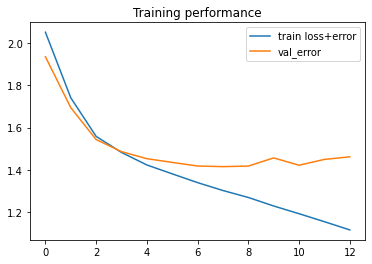

In [19]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

## Confusion matrix

In [20]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

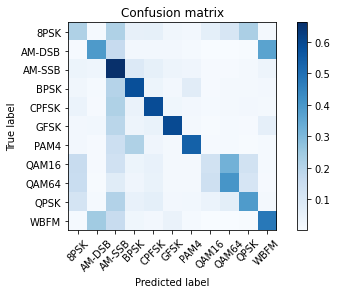

In [21]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=BATCH_SIZE)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1

for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plot_confusion_matrix(confnorm, labels=classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.08892921960072596


Overall Accuracy:  0.09936575052854123


Overall Accuracy:  0.1020714500150105


Overall Accuracy:  0.1245136186770428


Overall Accuracy:  0.15510568621613577


Overall Accuracy:  0.2046285018270402


Overall Accuracy:  0.28402903811252267


Overall Accuracy:  0.3807353388027955


Overall Accuracy:  0.44648779017184204


Overall Accuracy:  0.5337796713329276


Overall Accuracy:  0.6043343653250774


Overall Accuracy:  0.6462974111980735


Overall Accuracy:  0.6547987616099071


Overall Accuracy:  0.6807727690892365


Overall Accuracy:  0.6602150537634408


Overall Accuracy:  0.6671704957678356


Overall Accuracy:  0.678907435508346


Overall Accuracy:  0.68125


Overall Accuracy:  0.6770802042655452


Overall Accuracy:  0.6766320927394753


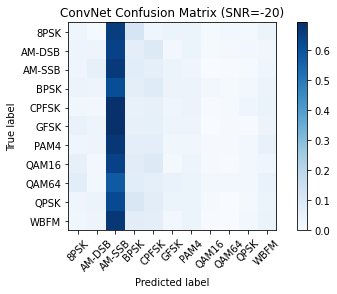

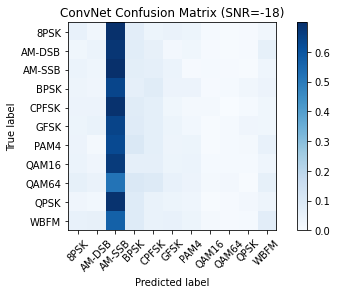

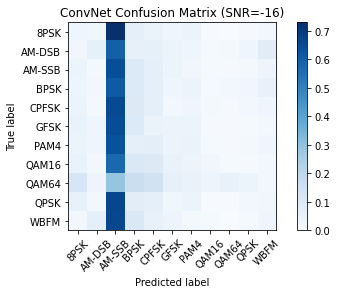

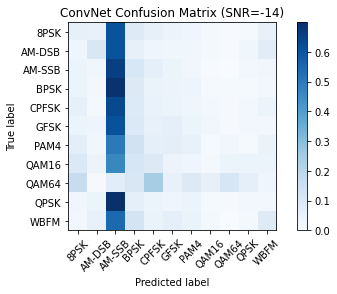

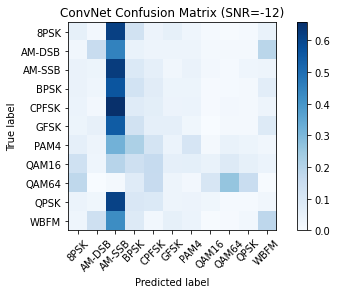

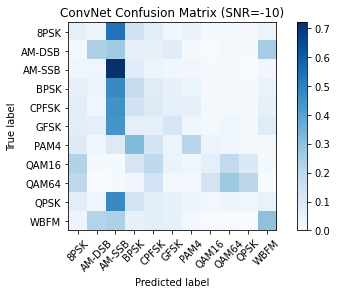

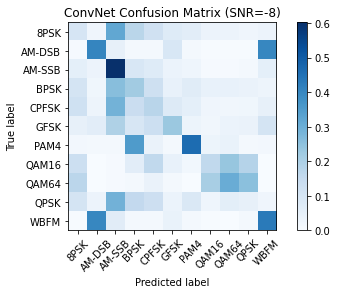

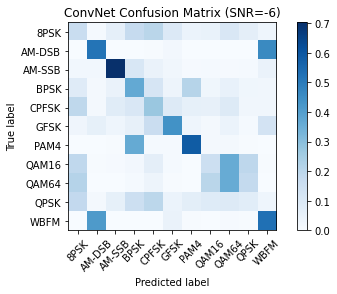

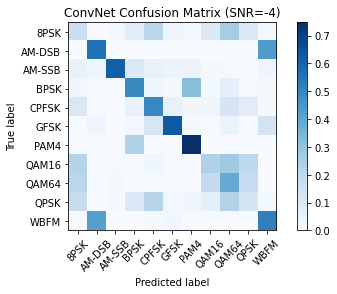

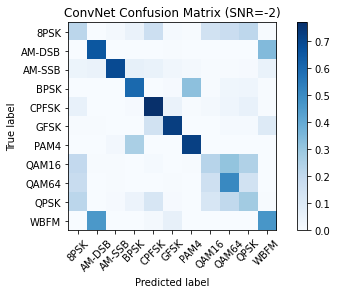

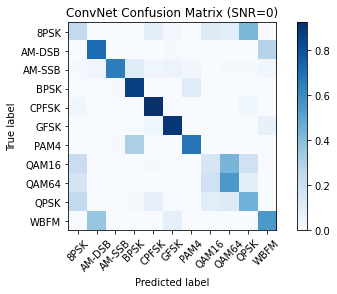

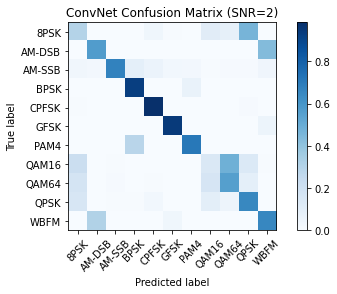

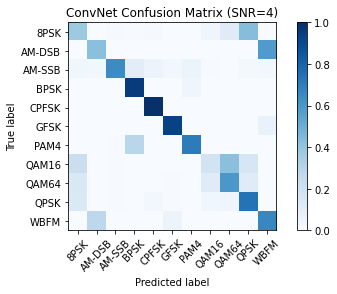

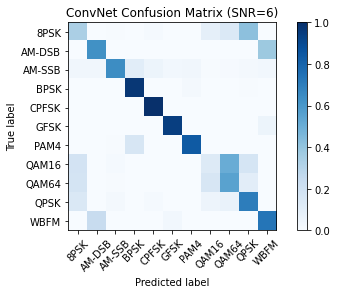

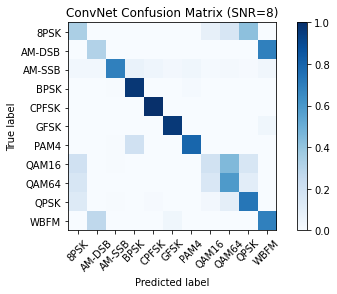

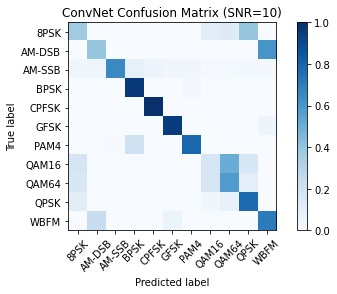

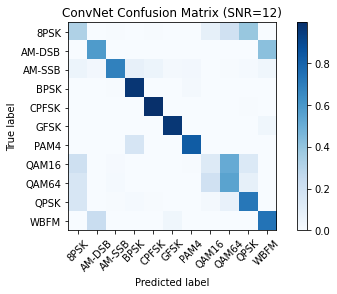

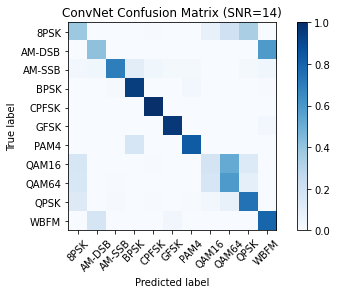

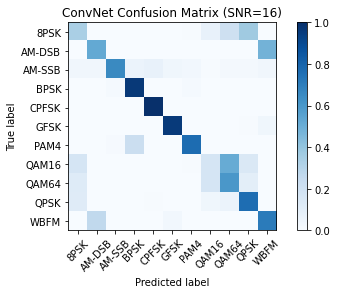

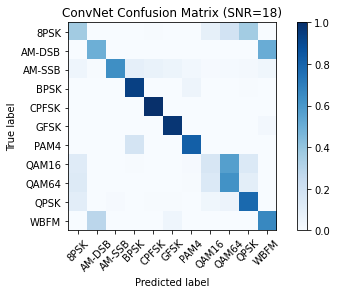

In [22]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(dataset_df[snr_column_dataframe_name][test_index])
    this_snr_indexes = np.where(np.array(test_SNRs) == snr)
    
    test_X_i = X_test[this_snr_indexes]
    test_Y_i = Y_test[this_snr_indexes]  

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
        
    for i in range(0,len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
        
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)

## Accuracy performance

In [23]:
accuracy_perc = {}
for el in acc.items():
    accuracy_perc[el[0]] = int(el[1] * 100)
    
accuracy_df = pd.DataFrame(data=accuracy_perc, index=["Accuracy %"])
# accuracy_df.columns = ["SNRs", "Accuracy"]
accuracy_df

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,8,9,10,12,15,20,28,38,44,53,60,64,65,68,66,66,67,68,67,67


In [24]:
# Save results to a pickle file for plotting later
fd = open(OUTPUT_FILENAME,'wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

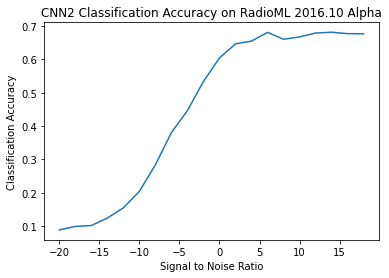

In [25]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")